# This notebook contains the final scripts used and analyses to identify sex linked markers for the ddRADseq dataset of <i>Rana arvalis</i> 

*Note that this notebook is a lot more "fleshed out" than the others, in order to show in more detail the scripts and proceedures used to explore the data and look for sex linked markers. Each species in Jeffries et al. 2018 required independent data exploration, parameter optimisation and validation, but this <i>R. arvalis</i> dataset contains pretty much all of the quirks identified in other datasets, e.g. wrongly sexed individuals, bad quality samples, multiple Y haplotypes. It also contains the subsampling analyses performed in an attempt to quantify the number of samples of each sex required for our tests of sex linked markers to work well. 

All functions used here can be found either in the Incremental module or MISC_RAD_tools modules available here:

https://github.com/DanJeffries/My_Dropbox_Scripts/tree/master/Python/My_Modules 

Just add the modules to your python path and you should be able to import them as below
   
**NOTE - these scripts were not explicitly written to be portable at first, so may need some tweaking. Incrementaly especially was written for early versions of Stacks. Doc strings exist for some functions, but certainly not all so feel free to contact me at dljeffries86@gmail.com if there are issues.

## Contents:

    - Data quality checks (e.g. per sample missing data / coverage)
    - Checks for cryptic population structure
    - Identification of putitative sex linked markers
    - Exploring the Y haplotype diversity
    - Subsampling tests
        - Multiple Y haplotypes
        - Downsampling equally across males and females
        - Downsampling with skew towards males or females


## <i>Rana arvalis</i> Sample set:

1 location . . . A pond in southeastern Austria (47°10 N, 16°5 E)

21 Females  
30 Males  

In [4]:
%matplotlib inline  
## Allows plots to be shown inside the notebook, rather than in a separate windo.
import os
import MISC_RAD_tools as MISC  ## Custom scripts
import pprint
import subprocess
import numpy

In [10]:
%load_ext rpy2.ipython 
## Module which allows us to run R code inside the notebook

## Stacks

Stacks was run on all individuals with default parameters, as preliminary tests on this data and others showed that these provide a good balance between the quantity and quality (i.e. reliability of genotypes) in the data. 

The final Populations command was:



    populations -b 1 -P ./ -M sex_info.txt -r 0.75 -p 2 --vcf --min_maf 0.05 > Populations.log 2>&1

### Checking per-sample data
First I will Check coverage across samples, in order to identify any low quality samples

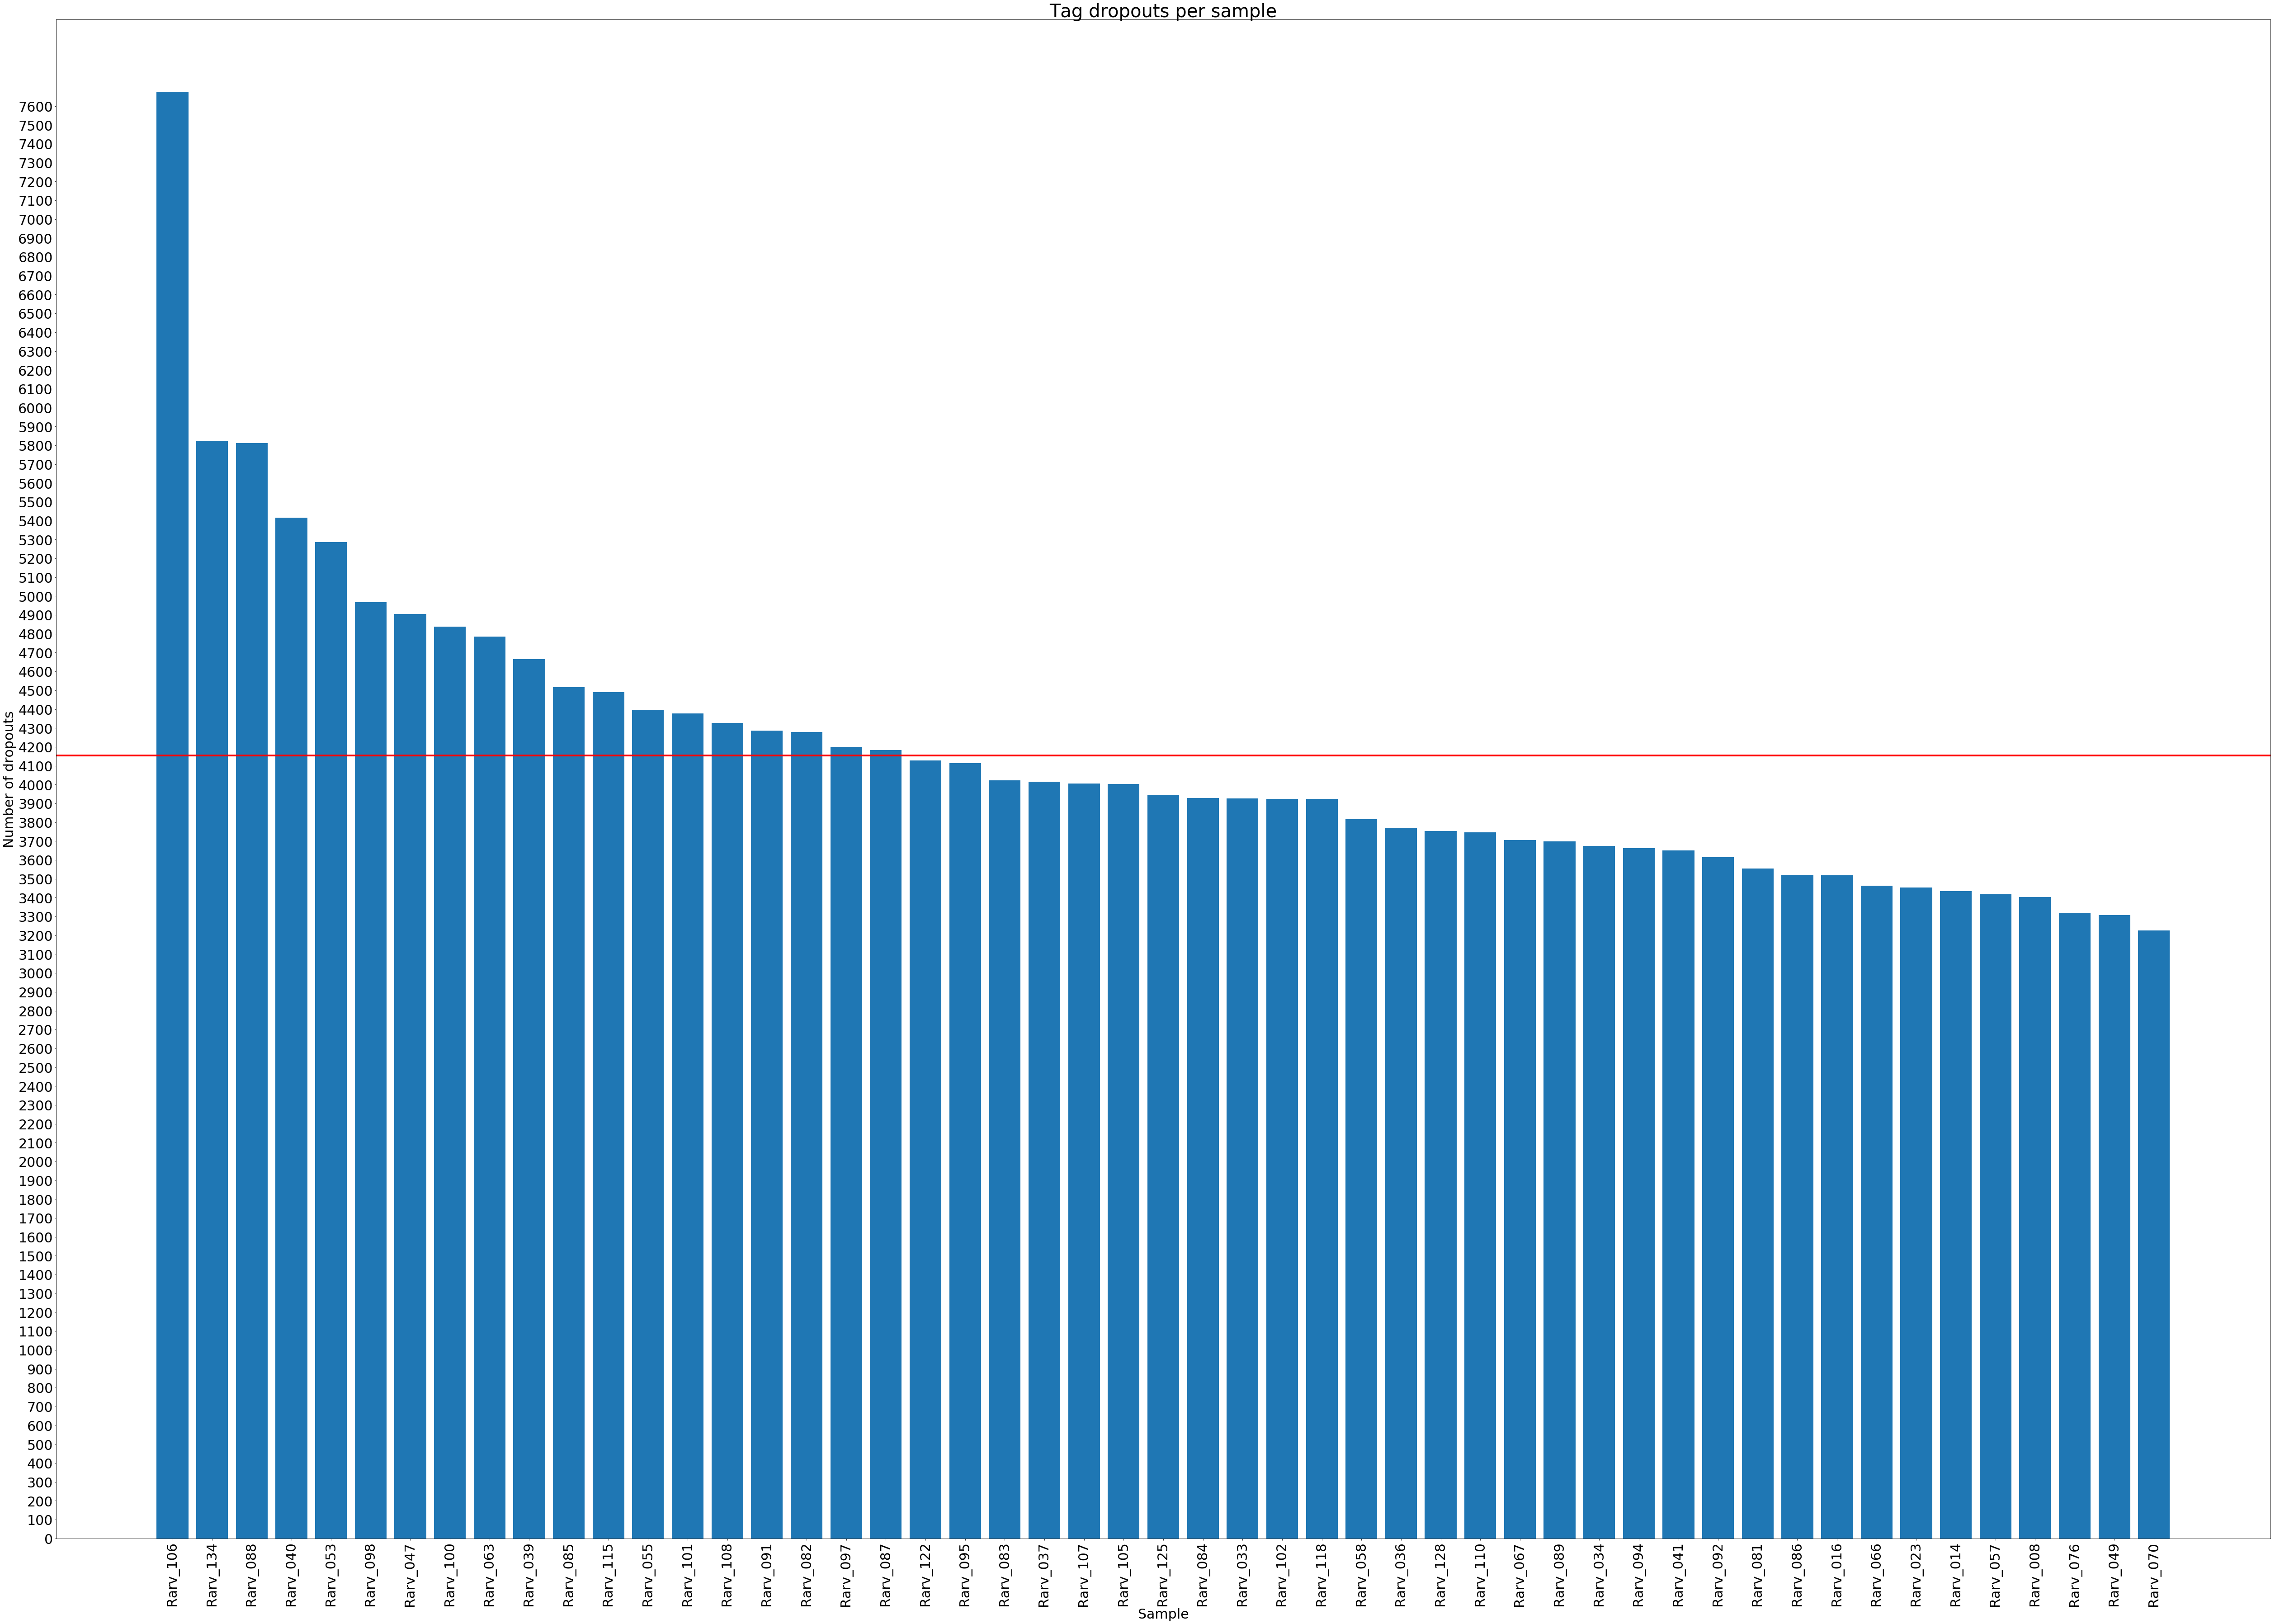

Outputs written to:
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_all//Tag_dropouts_per_sample.txt
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_all//Tag_dropouts_per_tag.txt
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_all//Tag_dropouts_per_sample.pdf
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_all//Tag_dropouts_per_tag.pdf
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_all//blacklist.txt


In [2]:
wd = "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_all/"

## The function below just plots the amount of missing genotype calls for all 

blacklist = MISC.missing_data_finder("%s/batch_1.vcf.altered" % wd, wd)

Just one bad sample, so removed Rarv_106, 

Note, in the Brelsford et al. 2016 paper, the entire dataset was used. In their analyses, they got 33,073 tags and 63,784 SNPs, using default stacks params, but slightly different filters. They filtered the final vcf for loci present in 75% of samples and wanted a min coverage of 7 reads. 

For me, before removing Rarv_106, I got 61307 tags, which gave 57768 SNPs, using stacks defaults, but I filtered slightly differently, I filtered for loci present in at least 75% of males and 75% of females. I also used the min_maf filter f 0.05, but no coverage cut-off. 


Re-check coverage

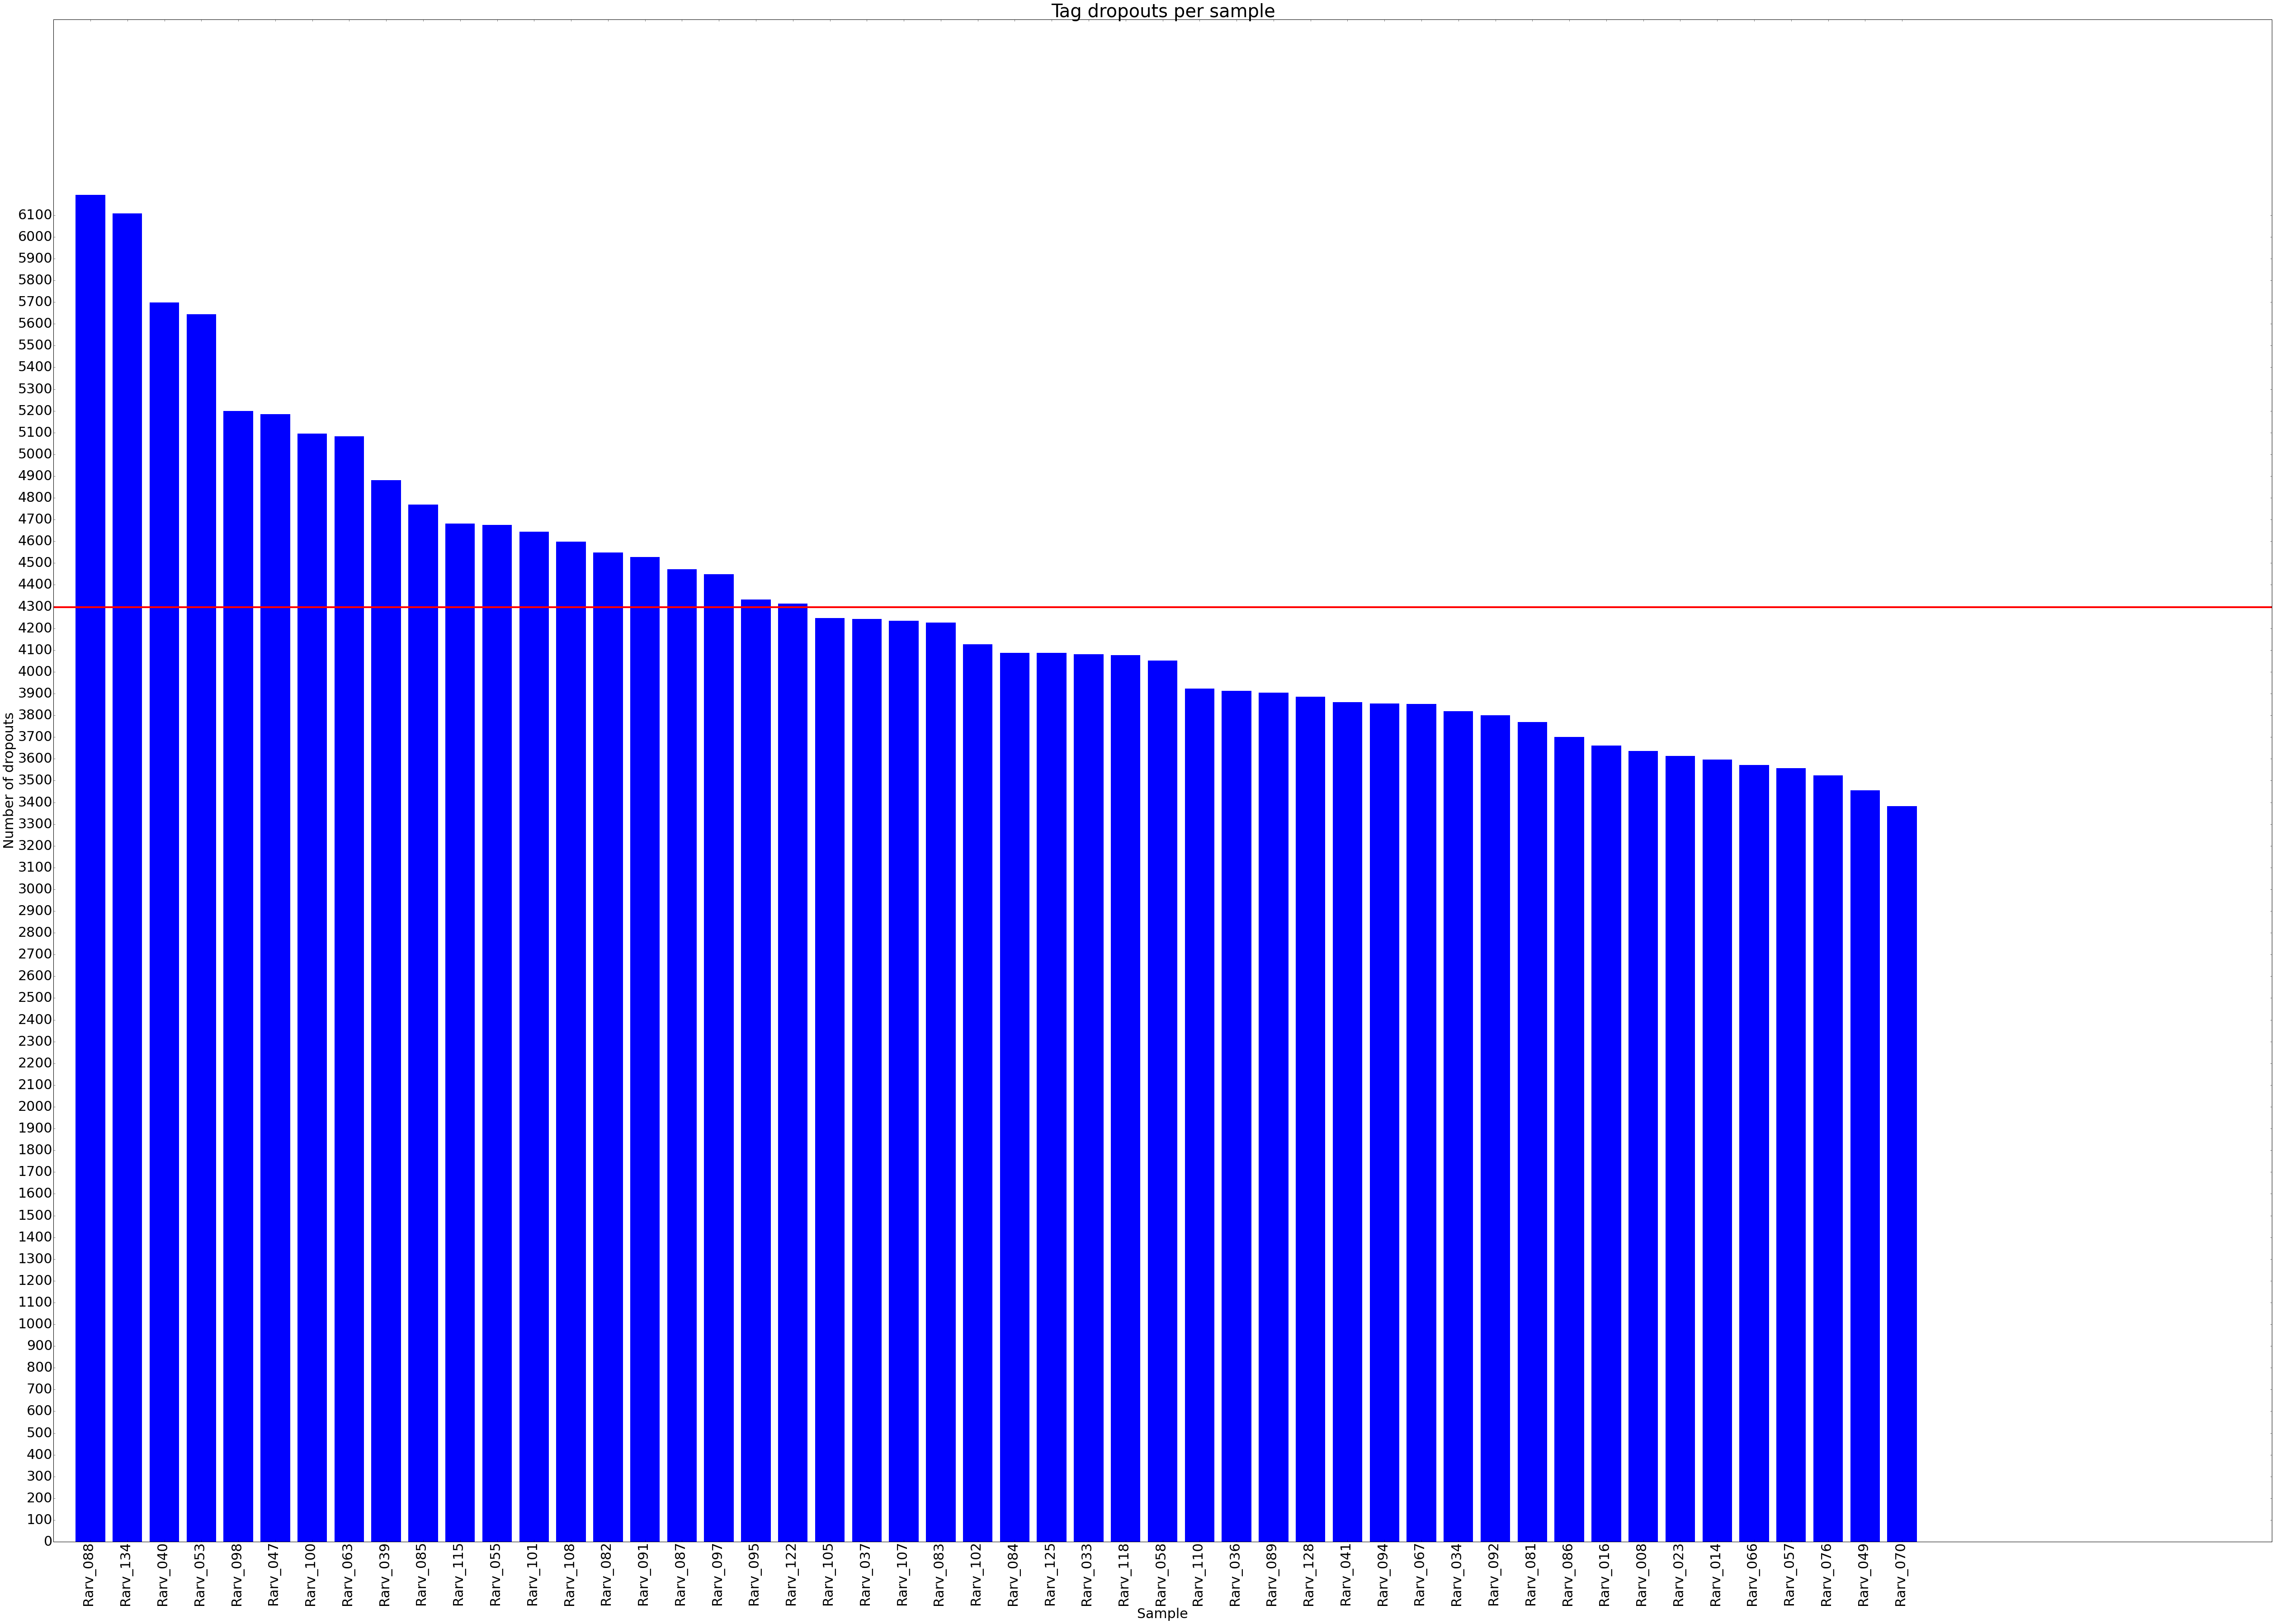

Outputs written to:
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept//Tag_dropouts_per_sample.txt
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept//Tag_dropouts_per_tag.txt
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept//Tag_dropouts_per_sample.pdf
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept//Tag_dropouts_per_tag.pdf
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept//blacklist.txt


In [8]:
wd = "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept/"

blacklist = MISC.missing_data_finder("%s/batch_1.vcf" % wd, wd)

I will also quickly check coverage

Number of tags =  57560
Average tag coverage 20.8589888088 (+- 12.5273756737 )


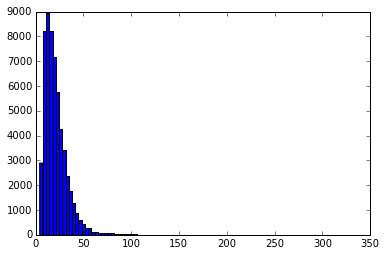

In [1]:
wd = "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2/"
final_vcf = "%s/batch_1.vcf" % wd
MISC.av_tag_cov(final_vcf, "%s/Av_tag_cov.out" % wd)


Looks good, average coverage of 20.85 is nice.

### Now run a PCA to look at the structure in the data . . . 

I usually do this at this stage in order to look for any cryptic population structure in the data. This could cause false positives if, for example, males and females were not separated equally among two or more populations. 

The PCA approach I use is from the adegenet R package. It requires genotype data in PLINK format so I first convert from VCF to PLINK using PLINK itself in the command line cell below (starting with the %%bash cell magic).

In [9]:
%%bash

wd=/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept/  ## just change this line

## All data 
sed 's/_/-/g' $wd/batch_1.vcf > $wd/batch_1_altered_adegenet.vcf

~/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/batch_1_altered_adegenet_plink


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept//batch_1_altered_adegenet_plink.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept//batch_1_altered_adegenet_plink
  --recode A
  --vcf /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept//batch_1_altered_adegenet.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept//batch_1_altered_adegenet_plink-temporary.bed
+
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept//batch_1_altered_adegenet_plink-temporary.bim
+
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept//batch_1_altered_adegenet_plink-temporary.fam
written.
59963 variants loaded from .bim file.
50 people (0 males, 0

Then I make the PCA just as I would in R. The %%R cell magic converts the cell to R language, with the help of rpy2 module loaded at the start of the notebook.

In [10]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.txt")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept/") 

## All SNPs 
alldata <- read.PLINK('batch_1_altered_adegenet_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 

## Sex information - just a two column text file with the sample name in the first column and the sex (M or F) in the second column. Its for labelling the PCA
sexes <- read.delim("../sex_info_kept.txt", header = F)

## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(alldata, parallel = TRUE, n.cores = 6, nf = 5) 



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



I plot the PCA using a custom script imported in the above cell using "source". You can find this script in the Github repo mentioned at the top of this notebook. 

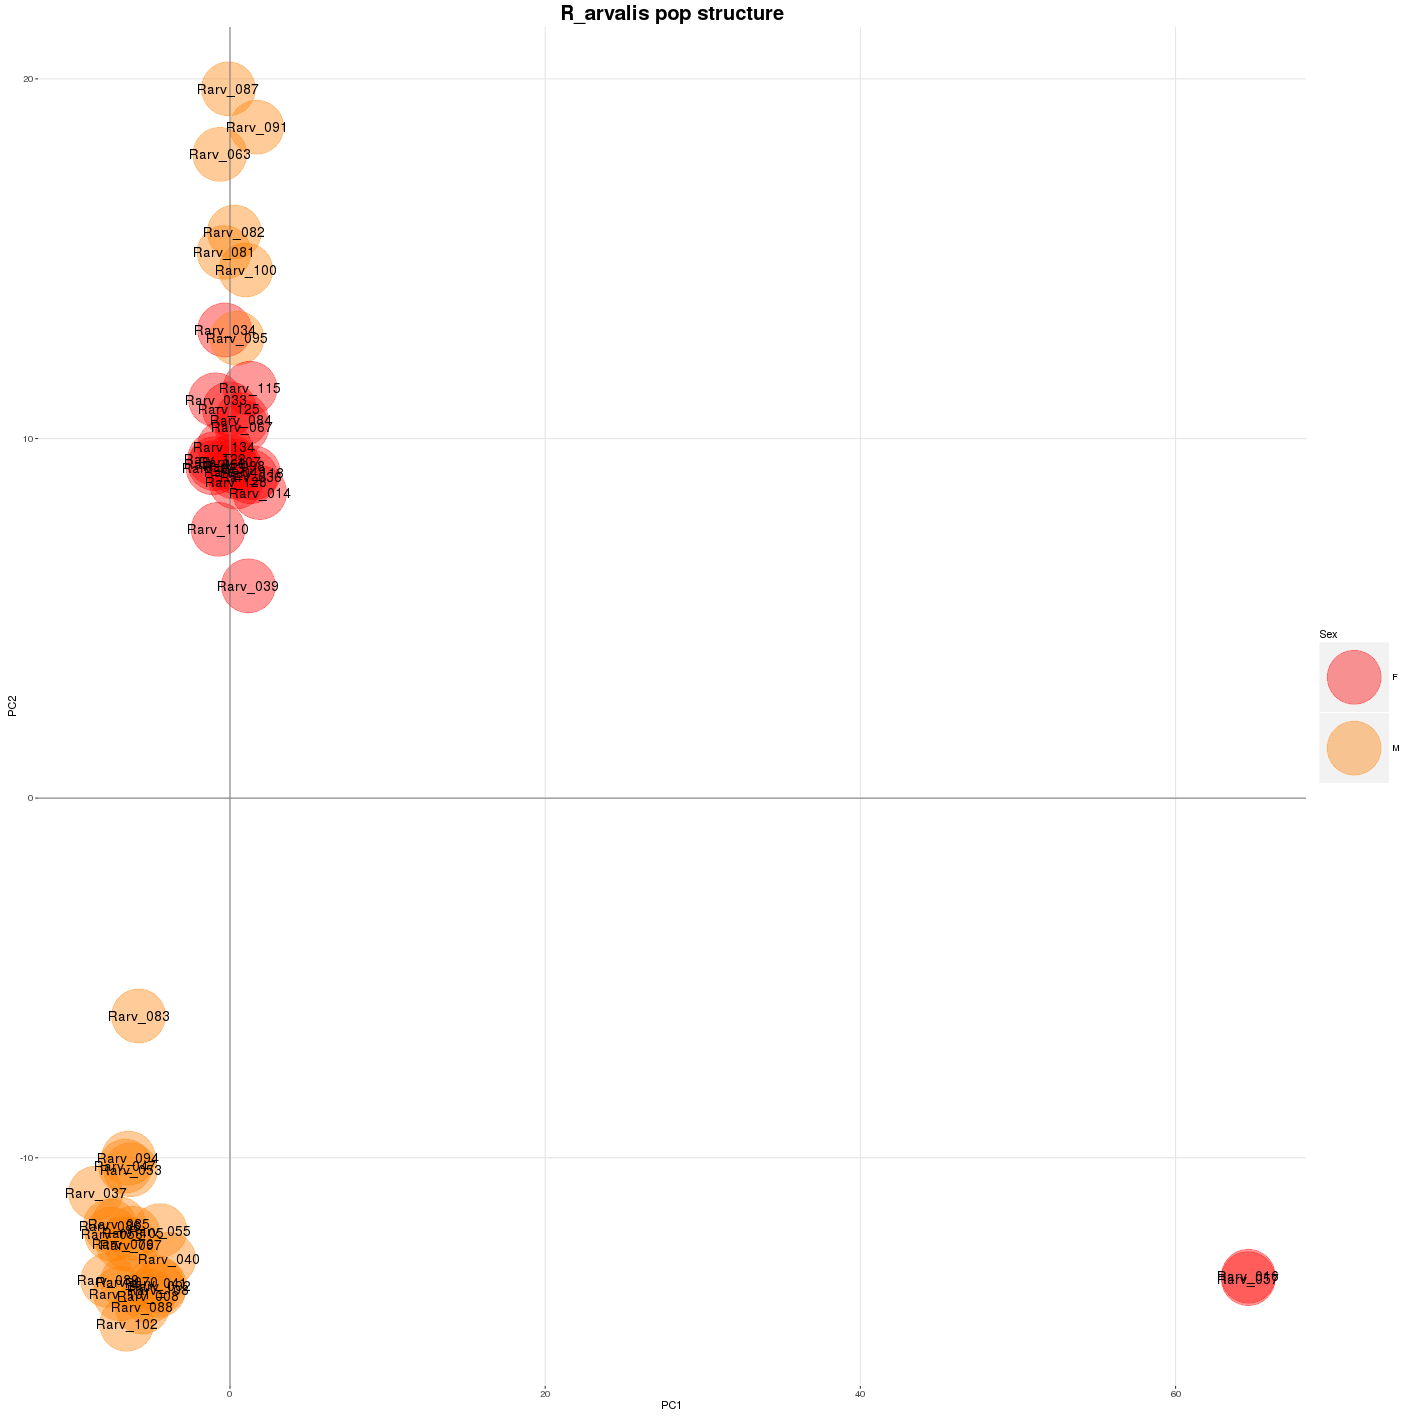

In [11]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "R_arvalis pop structure", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

So from a first look, this seems to be an interesting dataset. 

- Firstly, there are 2 samples, both females, which are far removed from the rest of the data (bottom right of PCA). This could be some immigration, or perhaps hybridisation, not sure if this occurs in arvalis, or what with.  

Whats really interesting is that these two samples, came out as being sex reversed in a previous analysis! So why would they, of all samples, be the ones which are outliers in their structure. . . ? Will follow up on these another time

- Secondly, there is clearly some male vs female signal here already, but only with a subset of the males (orange). 

So, as autosomal structure convolutes the search for sex linked markers, I will remove these two outlier females (Rarv_016, Rarv_057) and run populations once more.

Removing those two samples yeilded 60789 tags, containing 57560 SNPs after Populations

Now re-running the PCA


In [15]:
%%bash

wd=/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2/  ## just change this line

## All data 
sed 's/_/-/g' $wd/batch_1.vcf > $wd/batch_1_altered_adegenet.vcf

~/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/batch_1_altered_adegenet_plink


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2//batch_1_altered_adegenet_plink.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2//batch_1_altered_adegenet_plink
  --recode A
  --vcf /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2//batch_1_altered_adegenet.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2//batch_1_altered_adegenet_plink-temporary.bed
+
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2//batch_1_altered_adegenet_plink-temporary.bim
+
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2//batch_1_altered_adegenet_plink-temporary.fam
written.
57560 variants loaded from .bim file.
48 people

In [17]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.txt")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2/") 

## All SNPs (about 80,000)
alldata <- read.PLINK('batch_1_altered_adegenet_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 

## Sex information:
sexes <- read.delim("../sex_info_kept2.txt", header = F)

## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(alldata, parallel = TRUE, n.cores = 6, nf = 5) 



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.


 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



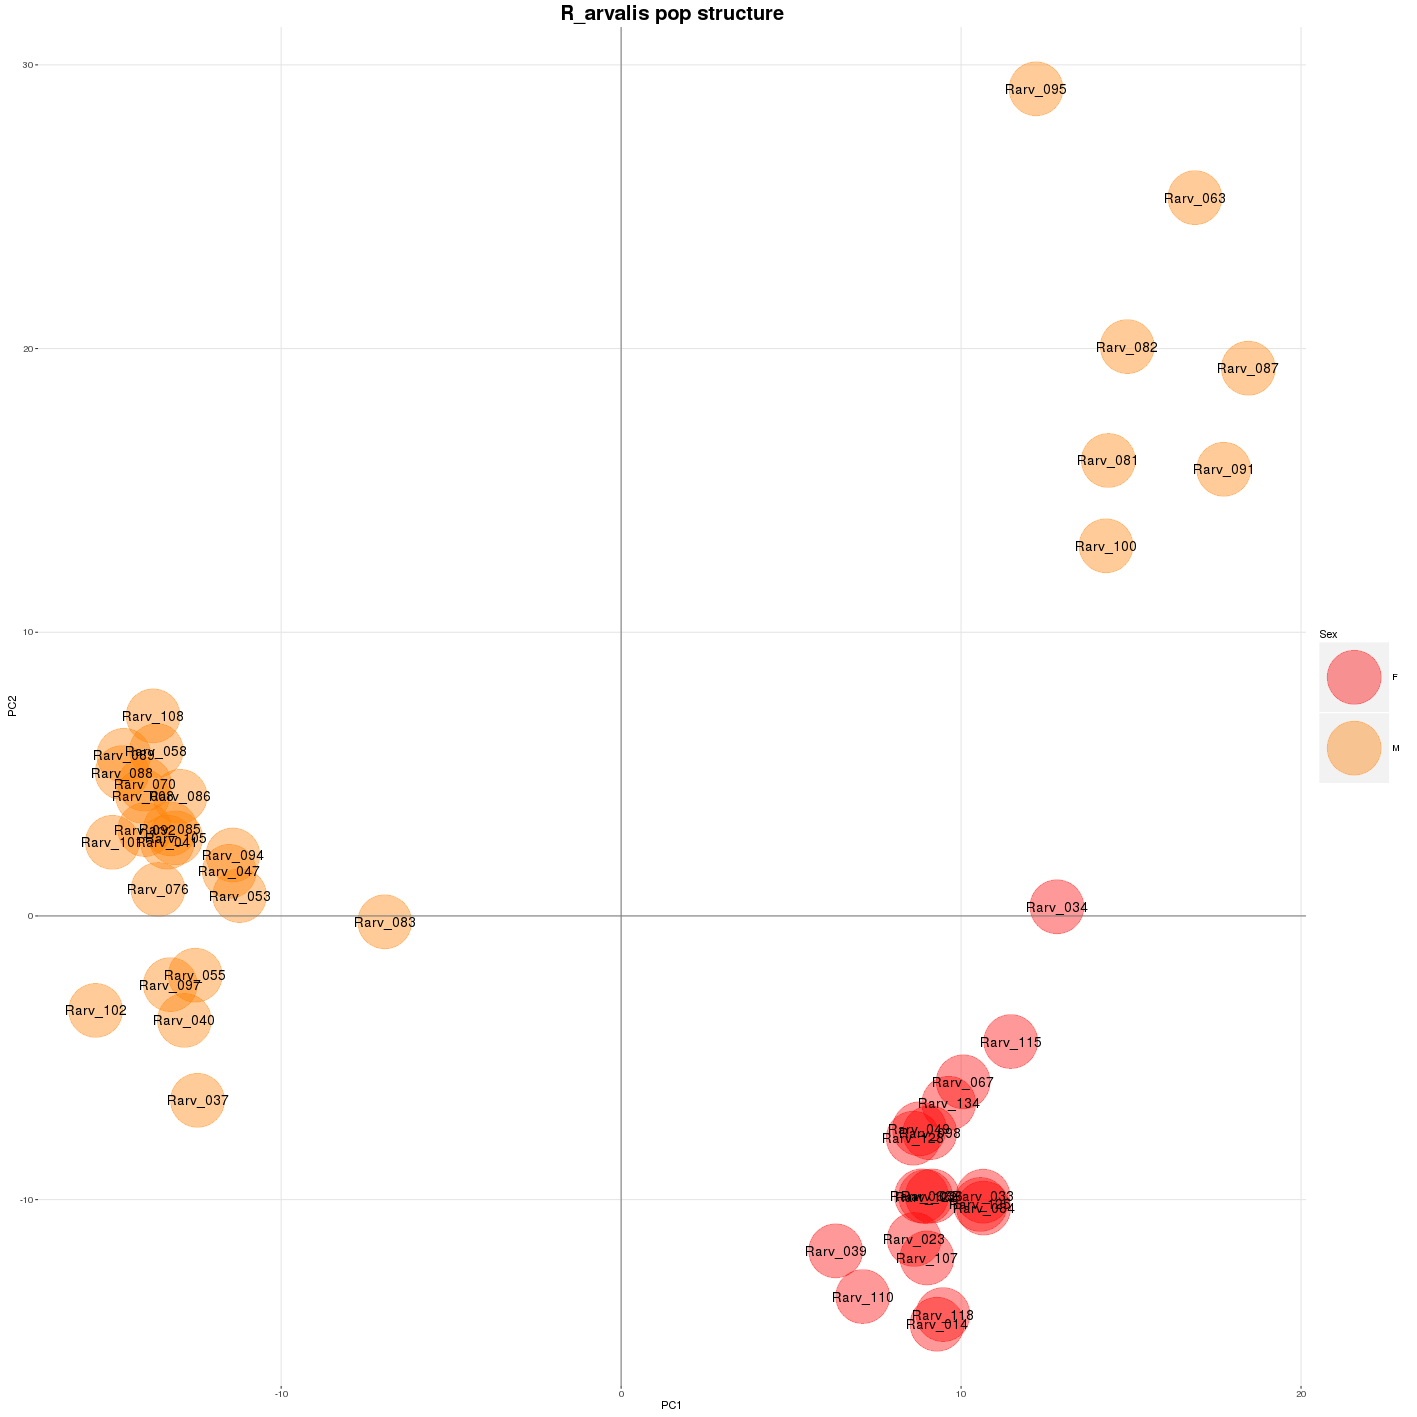

In [18]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "R_arvalis pop structure", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

Ok, so after removing those two samples and plotting the remaining samples at all 57570 snps, there is now clear male and female separation, and in fact there is also evidence of males of two different origins. 

Remember this is still before even looking for sex linked markers. So I will do that now.

I am using the scripts written based on three methods in the below paper:

Brelsford, A., Lavanchy, G., Sermier, R., Rausch, A., and Perrin, N. (2016). Identifying homomorphic sex chromosomes from wild-caught adults with limited genomic resources. Mol. Ecol. Resour. 17, 752–759. 

The "Super_SLM_finder" a.k.a. "Super sex-linked-marker finder" applies the three methods descibed in that paper one by one. The parameter dictionary below contains all the required information. You can change the values of the dictionary as you like (i.e. different paths, thresholds etc, but the Keys must stay the same. 

Run help(MISC.Super_SLM_finder) to see the details for running this function

In [23]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_kept_2/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Sex_ID_info_kept_2.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 0.9 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 0.9 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.




##### Using SNP frequency approach #### 

Number of loci = 57560
Number of samples = 48
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 57559
Number of putative X linked snps = 116
Number of putative X linked tags = 116
Number of putative Z linked markers = 7
Number of putative Z linked tags = 7


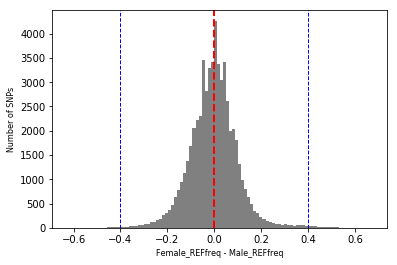


***DONE!***


##### Using SNP heterozygosity approach #####
 
Number of loci = 57560
Number of samples = 48
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 57559
Number of putative X linked snps = 159
Number of putative X linked tags = 159
Number of putative Z linked markers = 1
Number of putative Z linked tags = 1

 ### DONE! ### 


##### Using Sex specific tag approach ##### 


SUMMARY:
Number of females: 19
Number of males: 29
Number of Putative Y linked tags: 107
Number of Putative W linked tags: 0

 ### DONE! ###



/home/djeffrie/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib_venn/_venn3.py:61: UserWarning: Circle C has zero area
  warnings.warn("Circle C has zero area")


Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW

 ## After merging tags accross methods ## 

Final number of XY tags = 329
Final number of ZW tags = 8


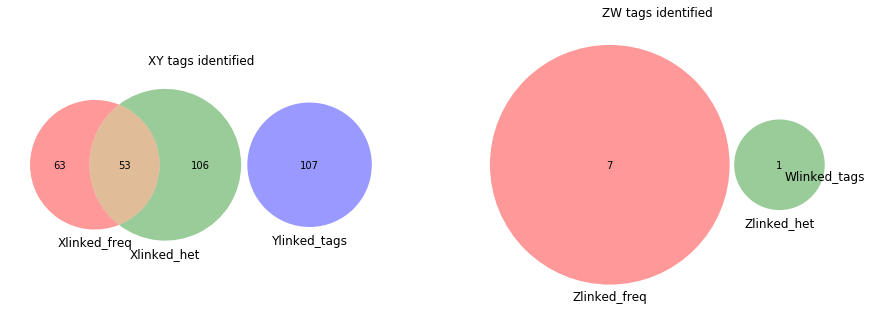

In [24]:
relaxedXYset, relaxedZWset = MISC.Super_SLM_finder(Parameter_dict, "111")

Now the parameter dictionary is set up, we can run the function. The string "111" in the function call tells it which of the three methods to call. "101" would use only the 1st and 3rd methods for example. The function outputs two dictionaries, the first contains the XY-like loci, and the second contains the ZW-like loci. 

The function will also print to screen a summary for each of the methods, a plot for the frequency method, and venn diagram to show overlap in identified sex linked markers between methods. 

Finally, 2 fasta files, one containing the XY markers and one containin the ZW markers will be outputted to the same directory as the Stacks catalog was in.


##### Using SNP frequency approach #### 

Number of loci = 57560
Number of samples = 48
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 57559
Number of putative X linked snps = 116
Number of putative X linked tags = 116
Number of putative Z linked markers = 7
Number of putative Z linked tags = 7


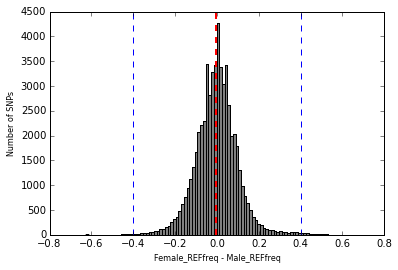


***DONE!***


##### Using SNP heterozygosity approach #####
 
Number of loci = 57560
Number of samples = 48
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 57559
Number of putative X linked snps = 159
Number of putative X linked tags = 159
Number of putative Z linked markers = 1
Number of putative Z linked tags = 1

 ### DONE! ### 


##### Using Sex specific tag approach ##### 


SUMMARY:
Number of males: 19
Number of males: 29
Number of Putative Y linked tags: 107
Number of Putative W linked tags: 0

 ### DONE! ###

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks

 ## After merging tags accross methods ## 

Final number of XY tags = 329
Final number of ZW tags = 8


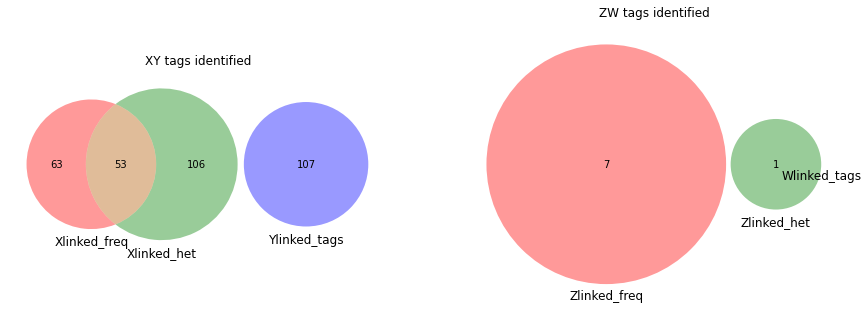

In [20]:
relaxedXYset, relaxedZWset = MISC.Super_SLM_finder(Parameter_dict, "111")

So, the three method together identified 329 XY-tags and 8 ZW-like! 

But with a dataset this good we could be more strict with our parameter thresholds if we liked, to reduce the number of false positives.

In [2]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW//Stacks/Sex_ID_info_kept_2.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1.0 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1.0 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.



##### Using SNP frequency approach #### 

Number of loci = 57560
Number of samples = 48
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 57559
Number of putative X linked snps = 51
Number of putative X linked tags = 51
Number of putative Z linked markers = 0
Number of putative Z linked tags = 0


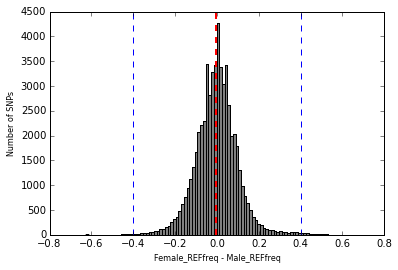


***DONE!***


##### Using SNP heterozygosity approach #####
 
Number of loci = 57560
Number of samples = 48
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 57559
Number of putative X linked snps = 101
Number of putative X linked tags = 101
Number of putative Z linked markers = 0
Number of putative Z linked tags = 0

 ### DONE! ### 


##### Using Sex specific tag approach ##### 


SUMMARY:
Number of males: 19
Number of males: 29
Number of Putative Y linked tags: 107
Number of Putative W linked tags: 0

 ### DONE! ###

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks

 ## After merging tags accross methods ## 

Final number of XY tags = 227
Final number of ZW tags = 0


/home/djeffrie/anaconda/lib/python2.7/site-packages/matplotlib_venn/_venn3.py:46: UserWarning: All circles have zero area
  warnings.warn("All circles have zero area")


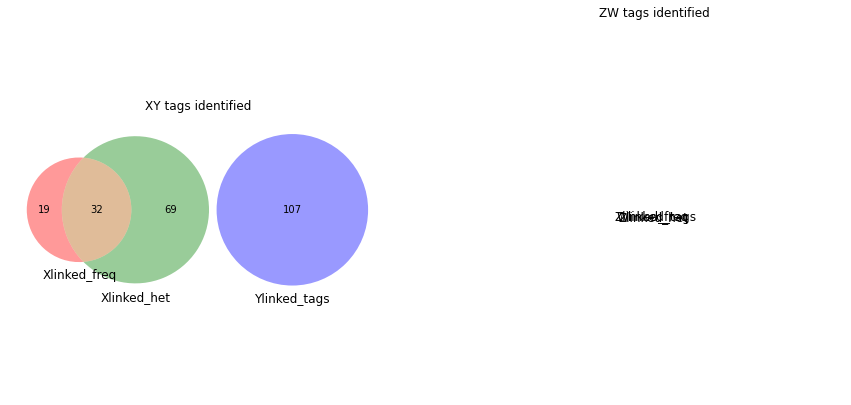

In [4]:
strictXYset, strictZWset = MISC.Super_SLM_finder(Parameter_dict, "111")

### So, being extremely strict, I find 227 XY markers, and no ZW! 

In Brelsford et al 2016 they find 292 sex linked markers. Being less strict I find 329, but also find ZW-like markers - some of which may be X-specific loci. 

## Mulitple Y haplotypes?

Now I will take a look at this issue of the two male groups in the PCA we ran. To do this I will make another PCA, but this time using only the sex linked markers we just identified. 

First, I will filter the VCF for only XY sex linked markers (using the more strict parameters) using another custom script

In [27]:
vcf_path = "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2/batch_1.vcf"

MISC.filter_vcf(vcf_path, strictXYset , "All_XY_linked_snps_freq_het.vcf")

Then convert to PLINK and make PCA in R again

In [28]:
%%bash

wd=/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2/  ## just change this line

## XY only data 
sed 's/_/-/g' $wd/All_XY_linked_snps_freq_het.vcf > $wd/All_XY_linked_snps_freq_het_altered_adegenet.vcf

~/Programs/plink_linux_x86_64/plink --vcf $wd/All_XY_linked_snps_freq_het_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/All_XY_linked_snps_freq_het_altered_adegenet 

PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2//All_XY_linked_snps_freq_het_altered_adegenet.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2//All_XY_linked_snps_freq_het_altered_adegenet
  --recode A
  --vcf /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2//All_XY_linked_snps_freq_het_altered_adegenet.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2//All_XY_linked_snps_freq_het_altered_adegenet-temporary.bed
+
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2//All_XY_linked_snps_freq_het_altered_adegenet-temporary.bim
+
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2//All_XY_linked_snps_freq_h

In [32]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.txt")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2/") 

## All SNPs (about 80,000)
alldata <- read.PLINK('All_XY_linked_snps_freq_het_altered_adegenet.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 

## Sex information:
sexes <- read.delim("../sex_info_kept2.txt", header = F)

## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(alldata, parallel = TRUE, n.cores = 6, nf = 5) 



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



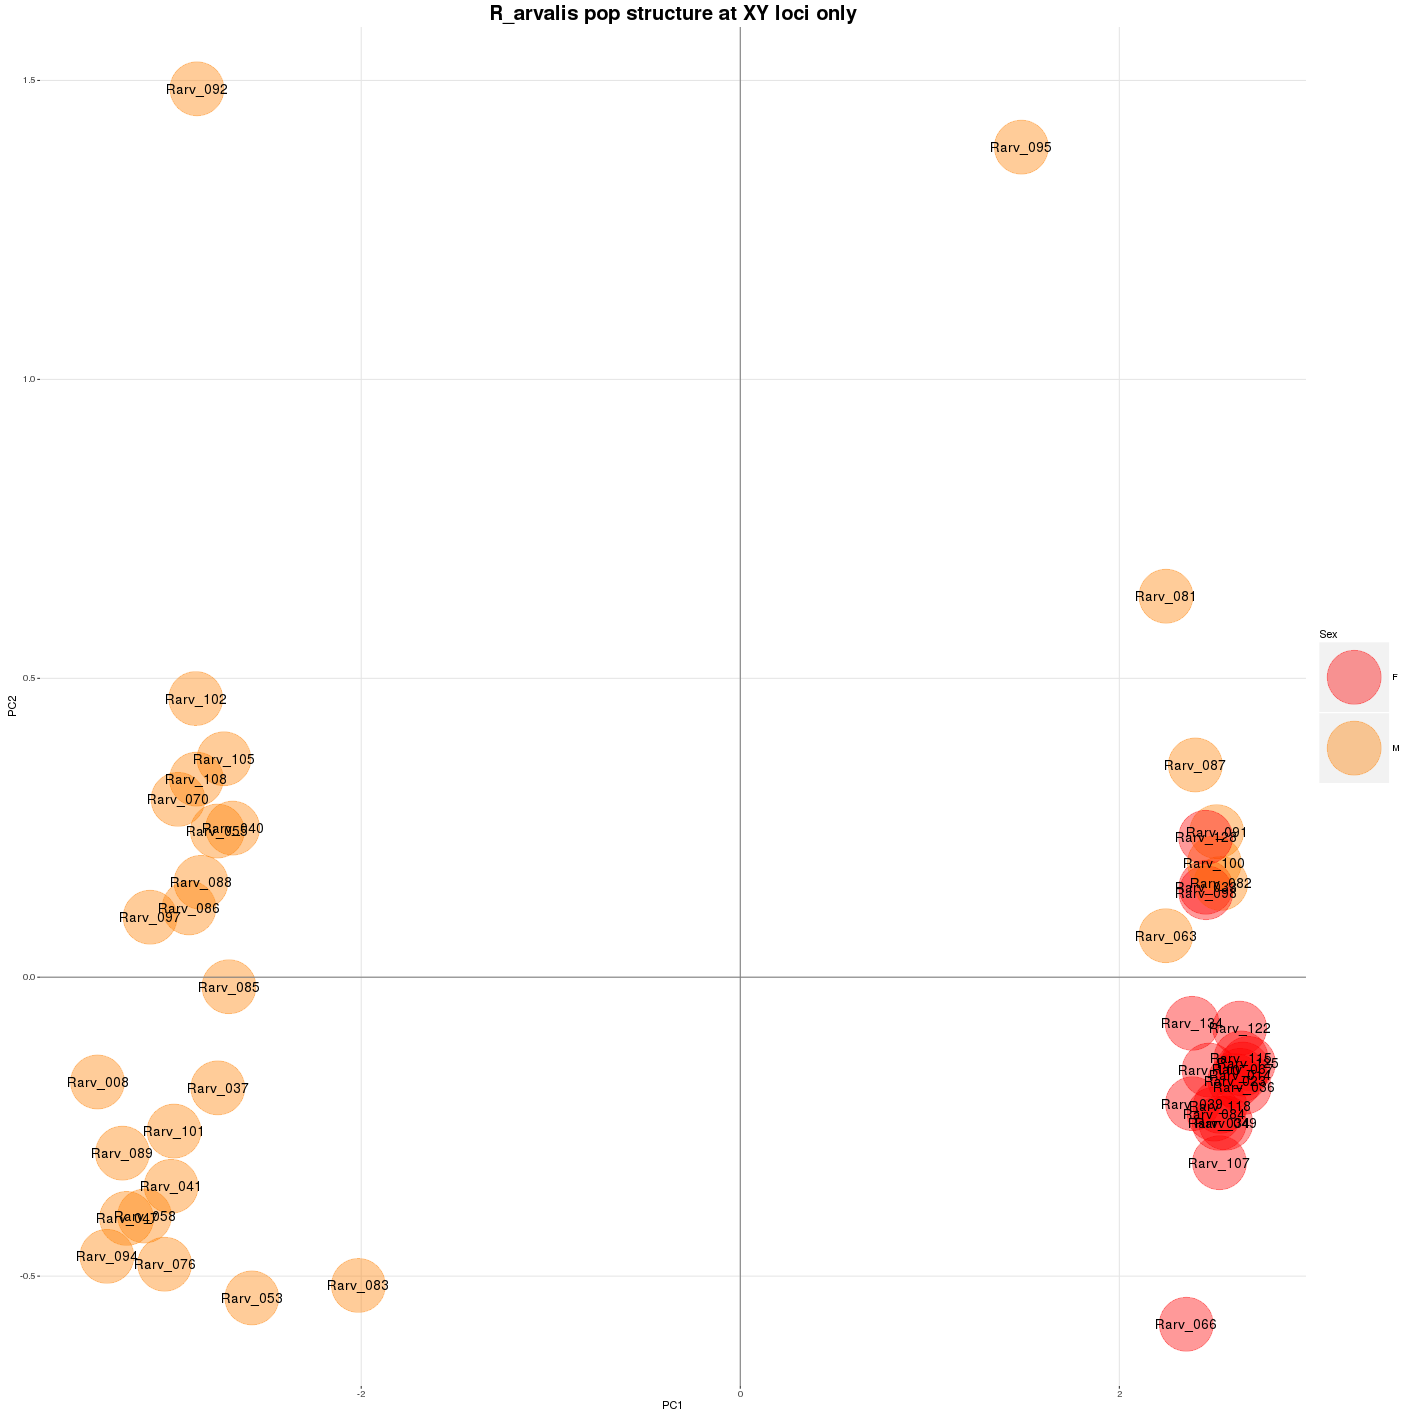

In [39]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,3), ## which components to plot
           Title = "R_arvalis pop structure at XY loci only", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

### Interestingly, there are several males which cluster with the females and can't be separated at these loci

I think what is happening is, when I am very strict with the parameters, there are some loci which are not shared by all haplotypes which get lost. These loci may be informative for some males however. So perhaps I try again with the more relaxed parameters from the first sex linked marker search above.

In [42]:
vcf_path = "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2/batch_1.vcf"

MISC.filter_vcf(vcf_path, relaxedXYset , "All_relaxed_XY_linked_snps_freq_het.vcf")

In [43]:
%%bash

wd=/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2/  ## just change this line

## XY only data 
sed 's/_/-/g' $wd/All_relaxed_XY_linked_snps_freq_het.vcf > $wd/All_relaxed_XY_linked_snps_freq_het_altered_adegenet.vcf

~/Programs/plink_linux_x86_64/plink --vcf $wd/All_relaxed_XY_linked_snps_freq_het_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/All_relaxed_XY_linked_snps_freq_het_altered_adegenet 

PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2//All_relaxed_XY_linked_snps_freq_het_altered_adegenet.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2//All_relaxed_XY_linked_snps_freq_het_altered_adegenet
  --recode A
  --vcf /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2//All_relaxed_XY_linked_snps_freq_het_altered_adegenet.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2//All_relaxed_XY_linked_snps_freq_het_altered_adegenet-temporary.bed
+
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2//All_relaxed_XY_linked_snps_freq_het_altered_adegenet-temporary.bim
+
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Popul

In [45]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.txt")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2/") 

## All SNPs (about 80,000)
alldata <- read.PLINK('All_relaxed_XY_linked_snps_freq_het_altered_adegenet.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 

## Sex information:
sexes <- read.delim("../sex_info_kept2.txt", header = F)

## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(alldata, parallel = TRUE, n.cores = 6, nf = 5) 



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



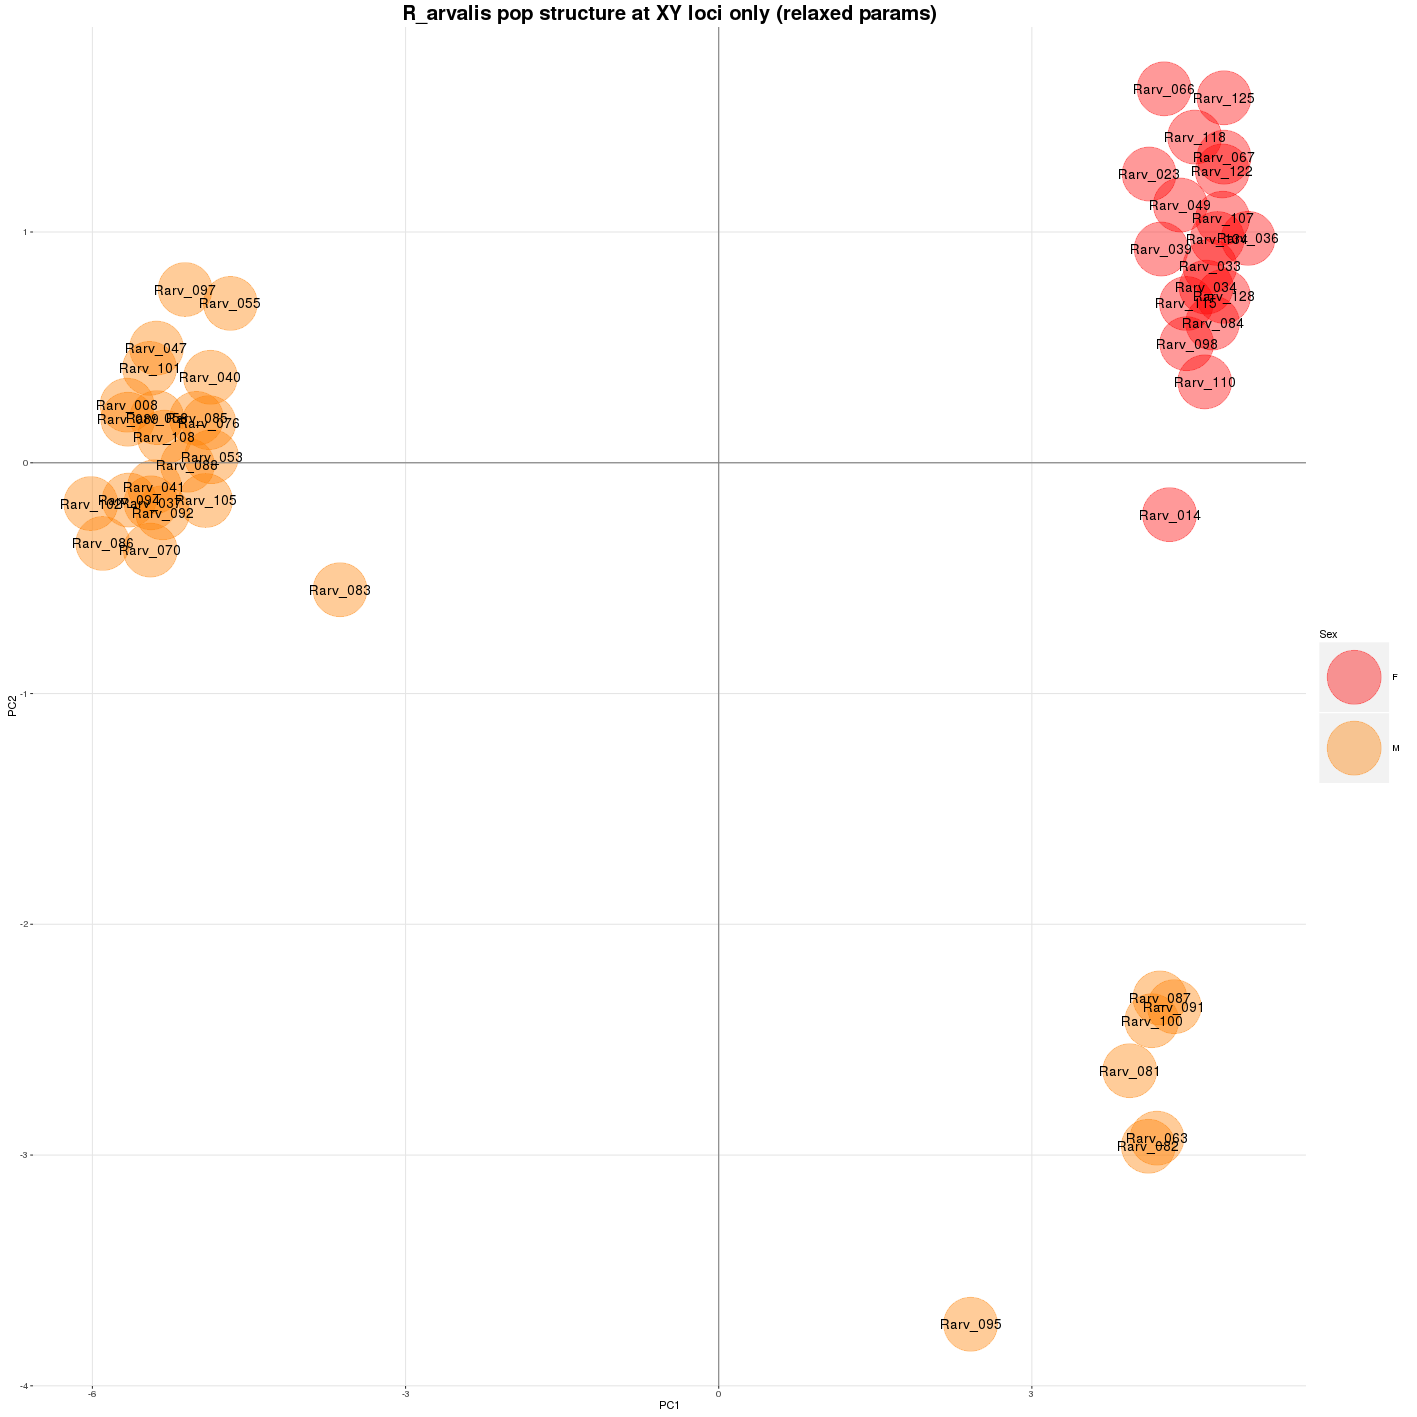

In [56]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "R_arvalis pop structure at XY loci only (relaxed params)", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

Ok so that seems to have done the trick. It looks like we really do have two Y haplotypes in this sample. To look at these in more detail, we can visualise their genotpyes using a heatmap. The heatmap function in R does this nicely, and also draws dendograms ordering samples (rows) and loci (columns) by similarity.

I have a small bash script called "Make_heatmap_input.sh" which does what it says on the tin. This can be run in a bash cell as below. I then make the heatmap in R.

In [47]:
%%bash

wd=/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2/

sh /home/djeffrie/Dropbox/My_Dropbox_Scripts/Bash/Make_heatmap_input.sh  $wd/All_relaxed_XY_linked_snps_freq_het_altered_adegenet.raw  $wd/All_relaxed_XY_linked_heatmap_input 

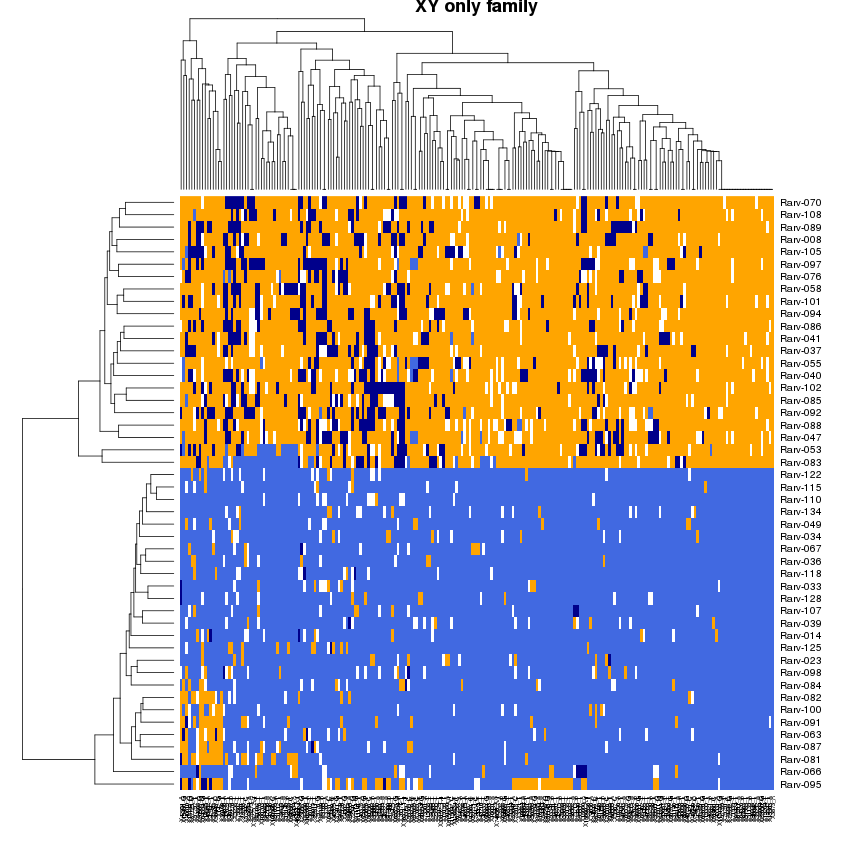

In [48]:
%%R -w 30 -h 30 -u cm

XY_heatmap_data <- read.delim("/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2/All_relaxed_XY_linked_heatmap_input.raw", row.names = 1)
XY_heatmap_data_sorted <- XY_heatmap_data[order(row.names(XY_heatmap_data), decreasing = T), ]
XY_heatmap_data_datmat <- as.matrix(XY_heatmap_data_sorted)

heatmap(XY_heatmap_data_datmat, scale='none', col = c("royalblue", "orange", "darkblue"), cexRow = 1, main = "XY only family")



Orange is a heterozygous genotype, so the males at the top stand out as being heterozygous for almost every locus in this set. There is some noise of course, likely due to missed heterozygous calls in the sequencing data for example. 

The females also stand out as being homozygous for the majority of loci. Then we have a group of samples at the bottom (Rarv 082,100,091,063,087,081,095) which for the most part are homozygous at these loci, except for a subset of loci on the very left of the plot, for which they are heterozgyous. So these are likely to be males with a different Y haplotype. 

So, it is interesting that with more relaxed parameters, I find a few more sex linked markers in the males of the other Y haplogroup. This is likely because there are fewers males with this haplotype in the sample set. So what if I relax them even more . . . ?


##### Using SNP frequency approach #### 

Number of loci = 57560
Number of samples = 48
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 57559
Number of putative X linked snps = 178
Number of putative X linked tags = 178
Number of putative Z linked markers = 35
Number of putative Z linked tags = 35


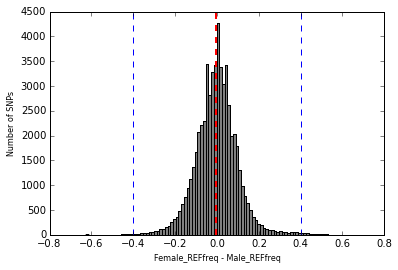


***DONE!***


##### Using SNP heterozygosity approach #####
 
Number of loci = 57560
Number of samples = 48
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 57559
Number of putative X linked snps = 433
Number of putative X linked tags = 433
Number of putative Z linked markers = 126
Number of putative Z linked tags = 126

 ### DONE! ### 


##### Using Sex specific tag approach ##### 


SUMMARY:
Number of males: 19
Number of males: 29
Number of Putative Y linked tags: 107
Number of Putative W linked tags: 0

 ### DONE! ###

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks

 ## After merging tags accross methods ## 

Final number of XY tags = 614
Final number of ZW tags = 161


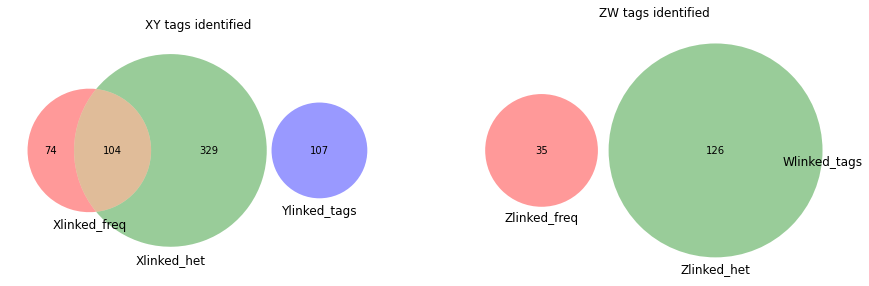

In [50]:
Parameter_dict['homogametic_REF_allele_freq'] = 0.8
Parameter_dict['homogamtic_homozygosity_threshold'] = 0.8
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.5
superrelaxedXYset, superrelaxedZWset = MISC.Super_SLM_finder(Parameter_dict, "111")

In [51]:
vcf_path = "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2/batch_1.vcf"
MISC.filter_vcf(vcf_path, superrelaxedXYset , "All_superrelaxed_XY_linked_snps_freq_het.vcf")

In [53]:
%%bash
wd=/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2/  ## just change this line

## XY only data 
sed 's/_/-/g' $wd/All_superrelaxed_XY_linked_snps_freq_het.vcf > $wd/All_superrelaxed_XY_linked_snps_freq_het_altered_adegenet.vcf

~/Programs/plink_linux_x86_64/plink --vcf $wd/All_superrelaxed_XY_linked_snps_freq_het_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/All_superrelaxed_XY_linked_snps_freq_het_altered_adegenet 


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2//All_superrelaxed_XY_linked_snps_freq_het_altered_adegenet.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2//All_superrelaxed_XY_linked_snps_freq_het_altered_adegenet
  --recode A
  --vcf /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2//All_superrelaxed_XY_linked_snps_freq_het_altered_adegenet.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2//All_superrelaxed_XY_linked_snps_freq_het_altered_adegenet-temporary.bed
+
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2//All_superrelaxed_XY_linked_snps_freq_het_altered_adegenet-temporary.bim
+
/home/djeffrie/Data/RADseq/

In [54]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.txt")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2/") 

## All SNPs (about 80,000)
alldata <- read.PLINK('All_superrelaxed_XY_linked_snps_freq_het_altered_adegenet.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 

## Sex information:
sexes <- read.delim("../sex_info_kept2.txt", header = F)

## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(alldata, parallel = TRUE, n.cores = 6, nf = 5) 



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



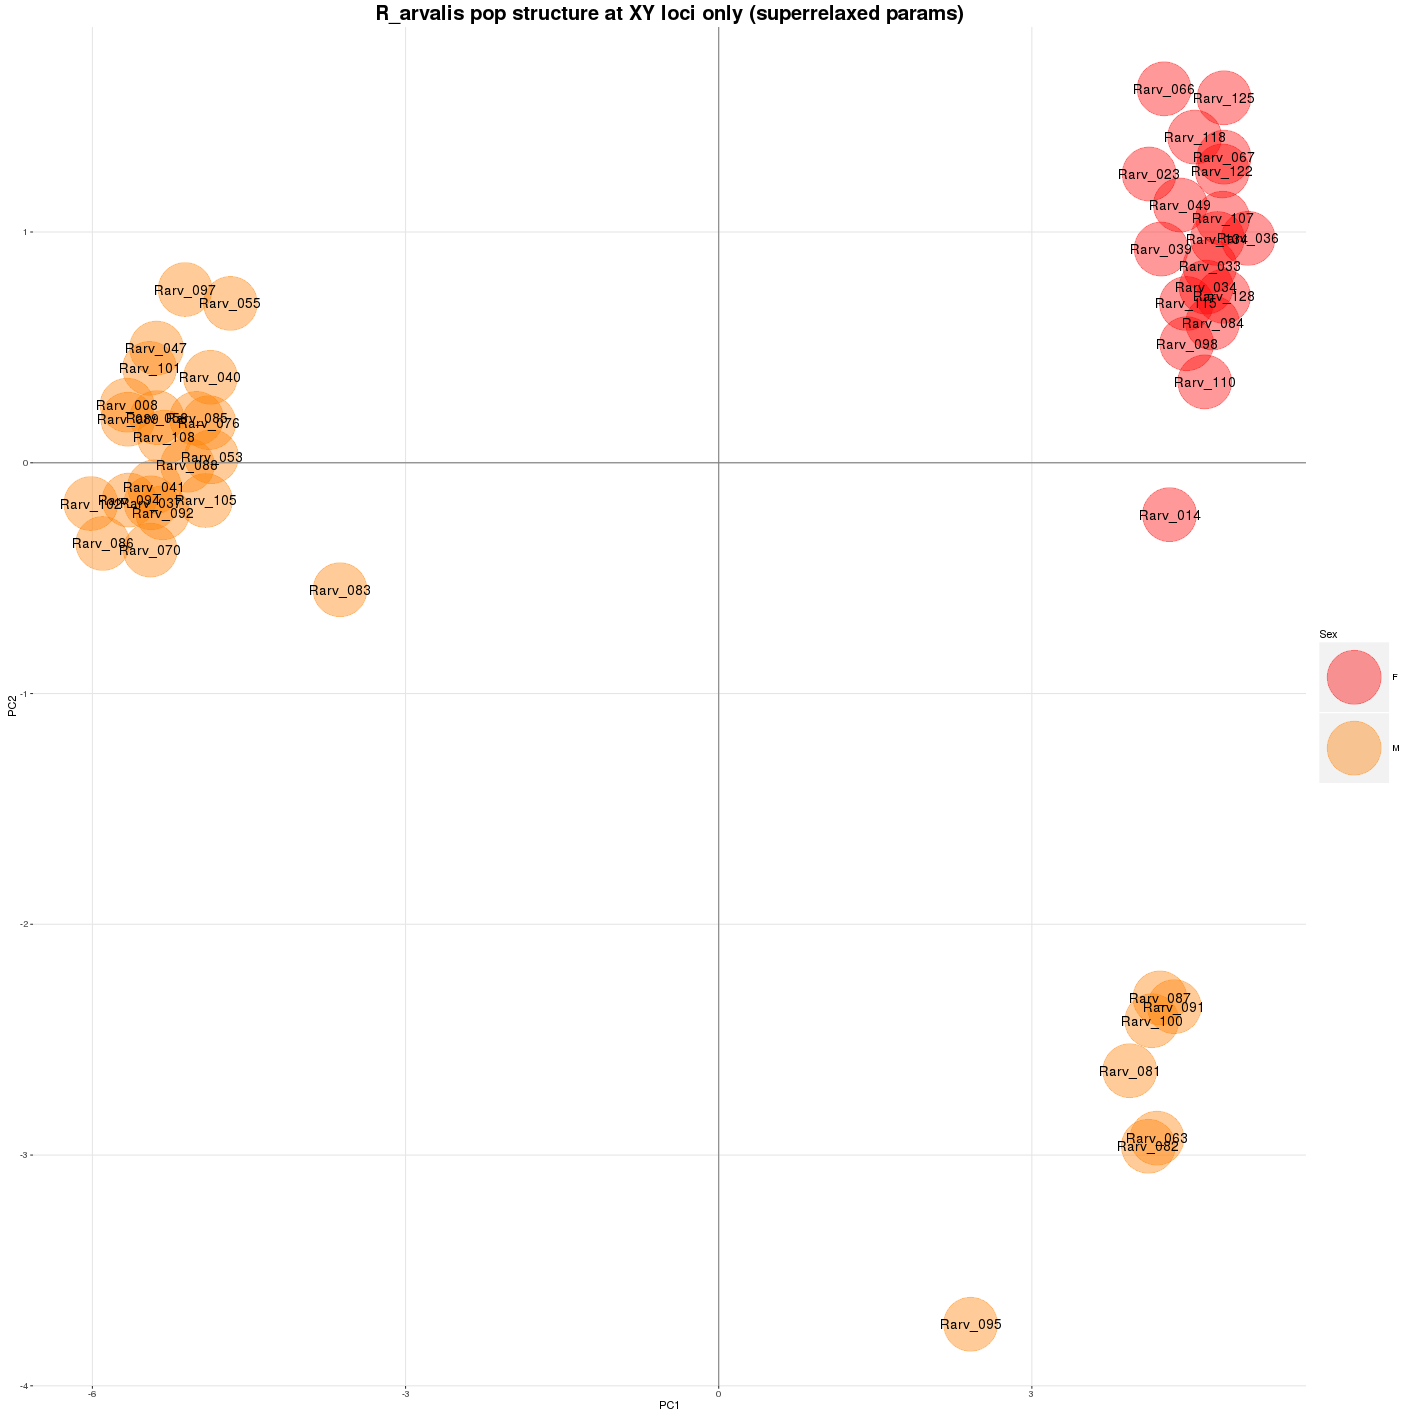

In [58]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "R_arvalis pop structure at XY loci only (superrelaxed params)", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

In [59]:
%%bash

wd=/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2/

sh /home/djeffrie/Dropbox/My_Dropbox_Scripts/Bash/Make_heatmap_input.sh  $wd/All_superrelaxed_XY_linked_snps_freq_het_altered_adegenet.raw  $wd/All_superrelaxed_XY_linked_heatmap_input 

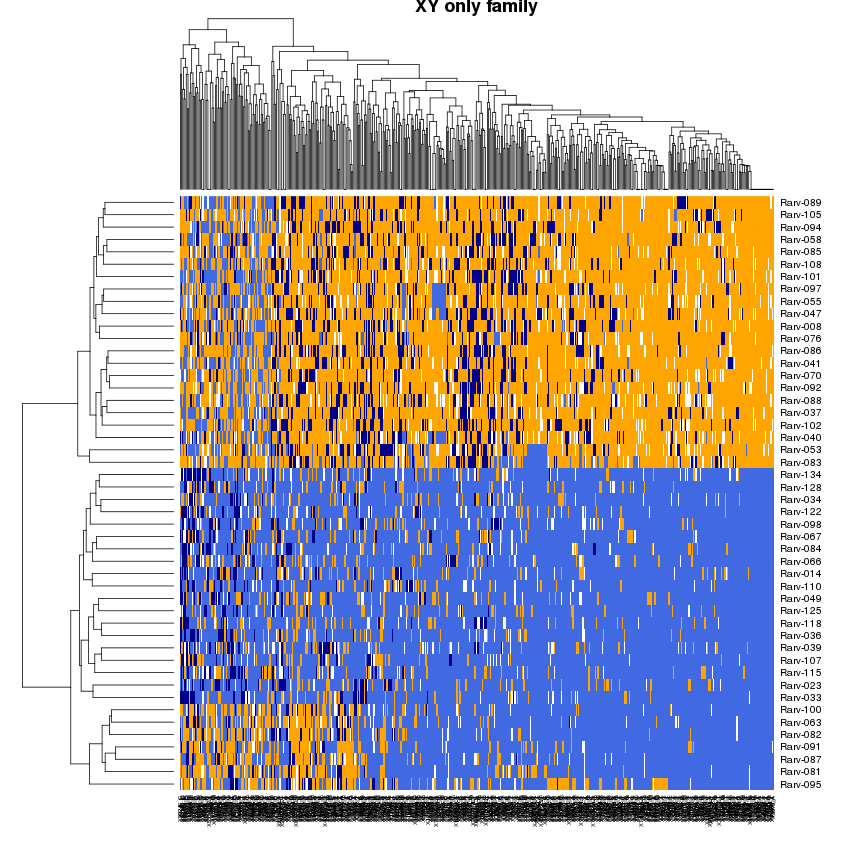

In [60]:
%%R -w 30 -h 30 -u cm

XY_heatmap_data <- read.delim("/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_kept_2/All_superrelaxed_XY_linked_heatmap_input.raw", row.names = 1)
XY_heatmap_data_sorted <- XY_heatmap_data[order(row.names(XY_heatmap_data), decreasing = T), ]
XY_heatmap_data_datmat <- as.matrix(XY_heatmap_data_sorted)

heatmap(XY_heatmap_data_datmat, scale='none', col = c("royalblue", "orange", "darkblue"), cexRow = 1, main = "XY only family")






So, it is clear that the more I relax these parameters, the more I allow sex linked markers from the smaller male haplogroup to be detected. So I cannot say that this haplogroup is closer to the X, as is suggested by the PCA, all I can say is that it is different from the other Y haplogroup, and that, as the number of males is smaller, my power to find difference between this Y haplogroup and the X is lower than for the larger haplogroup. 

As having two haplotypes in the dataset will obstruct tests for sex linked markers, one way to go would be to separate these male groups and perform this analyses separately. This will almost certainly improve things for the larger haplogroup, but for the smaller, there is likely to be too few males to be good enough for this analysis. However for completeness I will try it. 

So I re-ran populations using only the males from the first Y haplogroup:

<b>Y Haplogroup 1</b>

Males:  
Rarv_089  
Rarv_105  
Rarv_094  
Rarv_058  
Rarv_085  
Rarv_108  
Rarv_101  
Rarv_097  
Rarv_055  
Rarv_047  
Rarv_008  
Rarv_076  
Rarv_086  
Rarv_041  
Rarv_070  
Rarv_092  
Rarv_088  
Rarv_037  
Rarv_102  
Rarv_040  
Rarv_053  
Rarv_083  



In [61]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_Y_haplogroup_1/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW//Stacks/Sex_ID_info_Y_haplogroup_1.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 0.9 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 0.9 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.



##### Using SNP frequency approach #### 

Number of loci = 58288
Number of samples = 40
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 58287
Number of putative X linked snps = 233
Number of putative X linked tags = 233
Number of putative Z linked markers = 24
Number of putative Z linked tags = 24


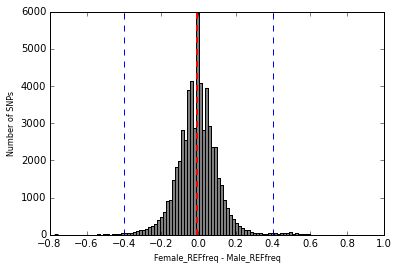


***DONE!***


##### Using SNP heterozygosity approach #####
 
Number of loci = 58288
Number of samples = 40
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 58287
Number of putative X linked snps = 186
Number of putative X linked tags = 186
Number of putative Z linked markers = 4
Number of putative Z linked tags = 4

 ### DONE! ### 


##### Using Sex specific tag approach ##### 


SUMMARY:
Number of males: 19
Number of males: 21
Number of Putative Y linked tags: 124
Number of Putative W linked tags: 6

 ### DONE! ###

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks

 ## After merging tags accross methods ## 

Final number of XY tags = 379
Final number of ZW tags = 34


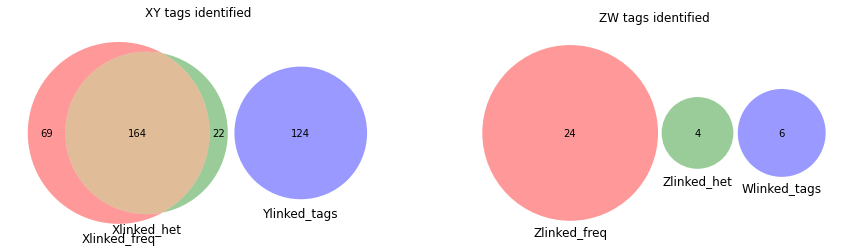

In [62]:
superrelaxedXYset, superrelaxedZWset = MISC.Super_SLM_finder(Parameter_dict, "111")

### Y haplogroup 1 strict


##### Using SNP frequency approach #### 

Number of loci = 58288
Number of samples = 40
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 58287
Number of putative X linked snps = 92
Number of putative X linked tags = 92
Number of putative Z linked markers = 2
Number of putative Z linked tags = 2


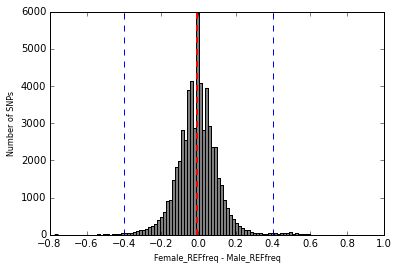


***DONE!***


##### Using SNP heterozygosity approach #####
 
Number of loci = 58288
Number of samples = 40
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 58287
Number of putative X linked snps = 120
Number of putative X linked tags = 120
Number of putative Z linked markers = 11
Number of putative Z linked tags = 11

 ### DONE! ### 


##### Using Sex specific tag approach ##### 


SUMMARY:
Number of males: 19
Number of males: 21
Number of Putative Y linked tags: 124
Number of Putative W linked tags: 6

 ### DONE! ###

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks

 ## After merging tags accross methods ## 

Final number of XY tags = 245
Final number of ZW tags = 19


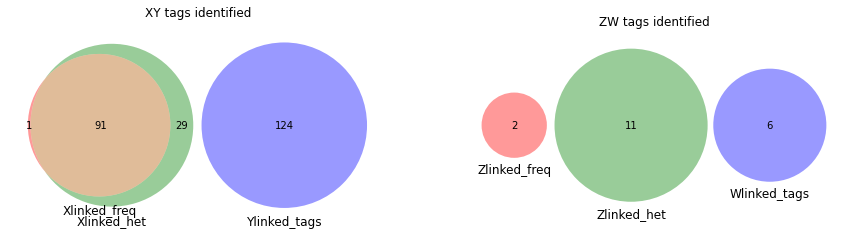

In [69]:
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_Y_haplogroup_1/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW//Stacks/Sex_ID_info_Y_haplogroup_1.txt"
Parameter_dict['homogametic_REF_allele_freq'] = 1
Parameter_dict['homogamtic_homozygosity_threshold'] = 1
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.5
strict_Y_hap_1_XYset, strict_Y_hap_1_ZWset = MISC.Super_SLM_finder(Parameter_dict, "111")


<b>Y Haplogroup 2</b>

Males:   
Rarv_063   
Rarv_081  
Rarv_082   
Rarv_087  
Rarv_091  
Rarv_095  
Rarv_100  

In [72]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_Y_haplogroup_2/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW//Stacks/Sex_ID_info_Y_haplogroup_2.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 0.8 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 0.8 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.



##### Using SNP frequency approach #### 

Number of loci = 51660
Number of samples = 26
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 51659
Number of putative X linked snps = 337
Number of putative X linked tags = 337
Number of putative Z linked markers = 191
Number of putative Z linked tags = 191


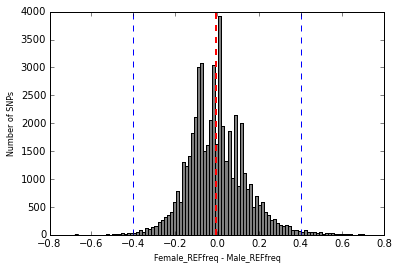


***DONE!***


##### Using SNP heterozygosity approach #####
 
Number of loci = 51660
Number of samples = 26
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 51659
Number of putative X linked snps = 339
Number of putative X linked tags = 339
Number of putative Z linked markers = 94
Number of putative Z linked tags = 94

 ### DONE! ### 


##### Using Sex specific tag approach ##### 


SUMMARY:
Number of males: 19
Number of males: 7
Number of Putative Y linked tags: 80
Number of Putative W linked tags: 162

 ### DONE! ###

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks

 ## After merging tags accross methods ## 

Final number of XY tags = 601
Final number of ZW tags = 440


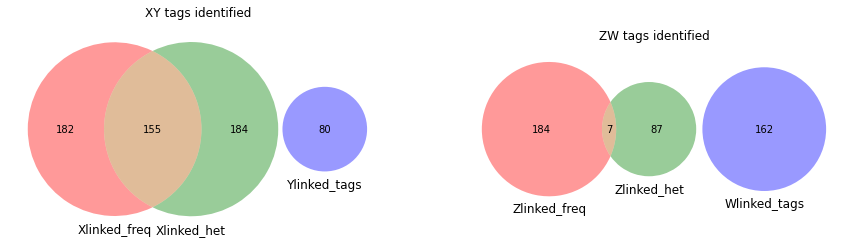

In [73]:
Y_Hap_2_XYset, Y_Hap_2_relaxedZWset = MISC.Super_SLM_finder(Parameter_dict, "111")

So there are a lot of ZW false positives here, I am sure that there are truly sex linked markers in those XY ones identified here, but there are likely to also be many false positivies there too. So it is difficult to compare this set with that of Y haplogroup 1. 

# SUMMARY - Finding the sex chromosome

So . . . . 

This dataset is very nice, and has some interesting quirks. The most important of which is that the males in the dataset are split between two Y haplogroups. The first has 21 males in it, the second has 7. This means that, when males from both groups are included in the analyses, a lot of sex linked markers could be overlooked becuase they are sex linked in one haplotype, but not the other (this is tested below). 

So, when being strict, the analysis is heavily biased towards the larger haplogroup, however, when being more relaxed, more loci are found for the smaller haplogroup. 

The obvious thing to do is to split these males apart and perform the analyses for each haplogroup separately, however, the smaller haplogroup consists of only 7 males, meaning it is quite prone to false positives. That said, there is still a large bias towards an XY system (which goes against the skew of males and females in the dataset) and also, there is much more agreement between the freq and het methods than for the ZW.

For the full dataset using more relaxed parameters, I find:
 - 329 XY markers and 
 - 8 ZW markers. 
 
So for the purposes of finding the sex chromosome for this species, the next step is to run the sex-assignment permutations, which will tell me how many sex-linked false positives to expect in the dataset. This is done in the Randomisations ipython notebook.

Below are some further analyses, firstly to look at these weird two samples which fall outside the other samples in the initial PCA, and secondly the subsampling analyses to see how the number of samples, number of Y haplotypes and skew towards males or females affects the power to find sex linked markers.



## Side question:

I noticed that the samples fall out from the other samples in the initial PCA. So I want to see whats going on. . . 

here's the Initial PCA again, before any sample filtering

In [74]:
%%bash

wd=/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_all/  ## just change this line

## All data 
sed 's/_/-/g' $wd/batch_1.vcf > $wd/batch_1_altered_adegenet.vcf

~/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/batch_1_altered_adegenet_plink


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_all//batch_1_altered_adegenet_plink.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_all//batch_1_altered_adegenet_plink
  --recode A
  --vcf /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_all//batch_1_altered_adegenet.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_all//batch_1_altered_adegenet_plink-temporary.bed
+
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_all//batch_1_altered_adegenet_plink-temporary.bim
+
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_all//batch_1_altered_adegenet_plink-temporary.fam
written.
57768 variants loaded from .bim file.
51 people (0 males, 0 femal

In [75]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.txt")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_all/") 

## All SNPs (about 80,000)
alldata <- read.PLINK('batch_1_altered_adegenet_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 

## Sex information:
sexes <- read.delim("../sex_info.txt", header = F)

## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(alldata, parallel = TRUE, n.cores = 6, nf = 5) 



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



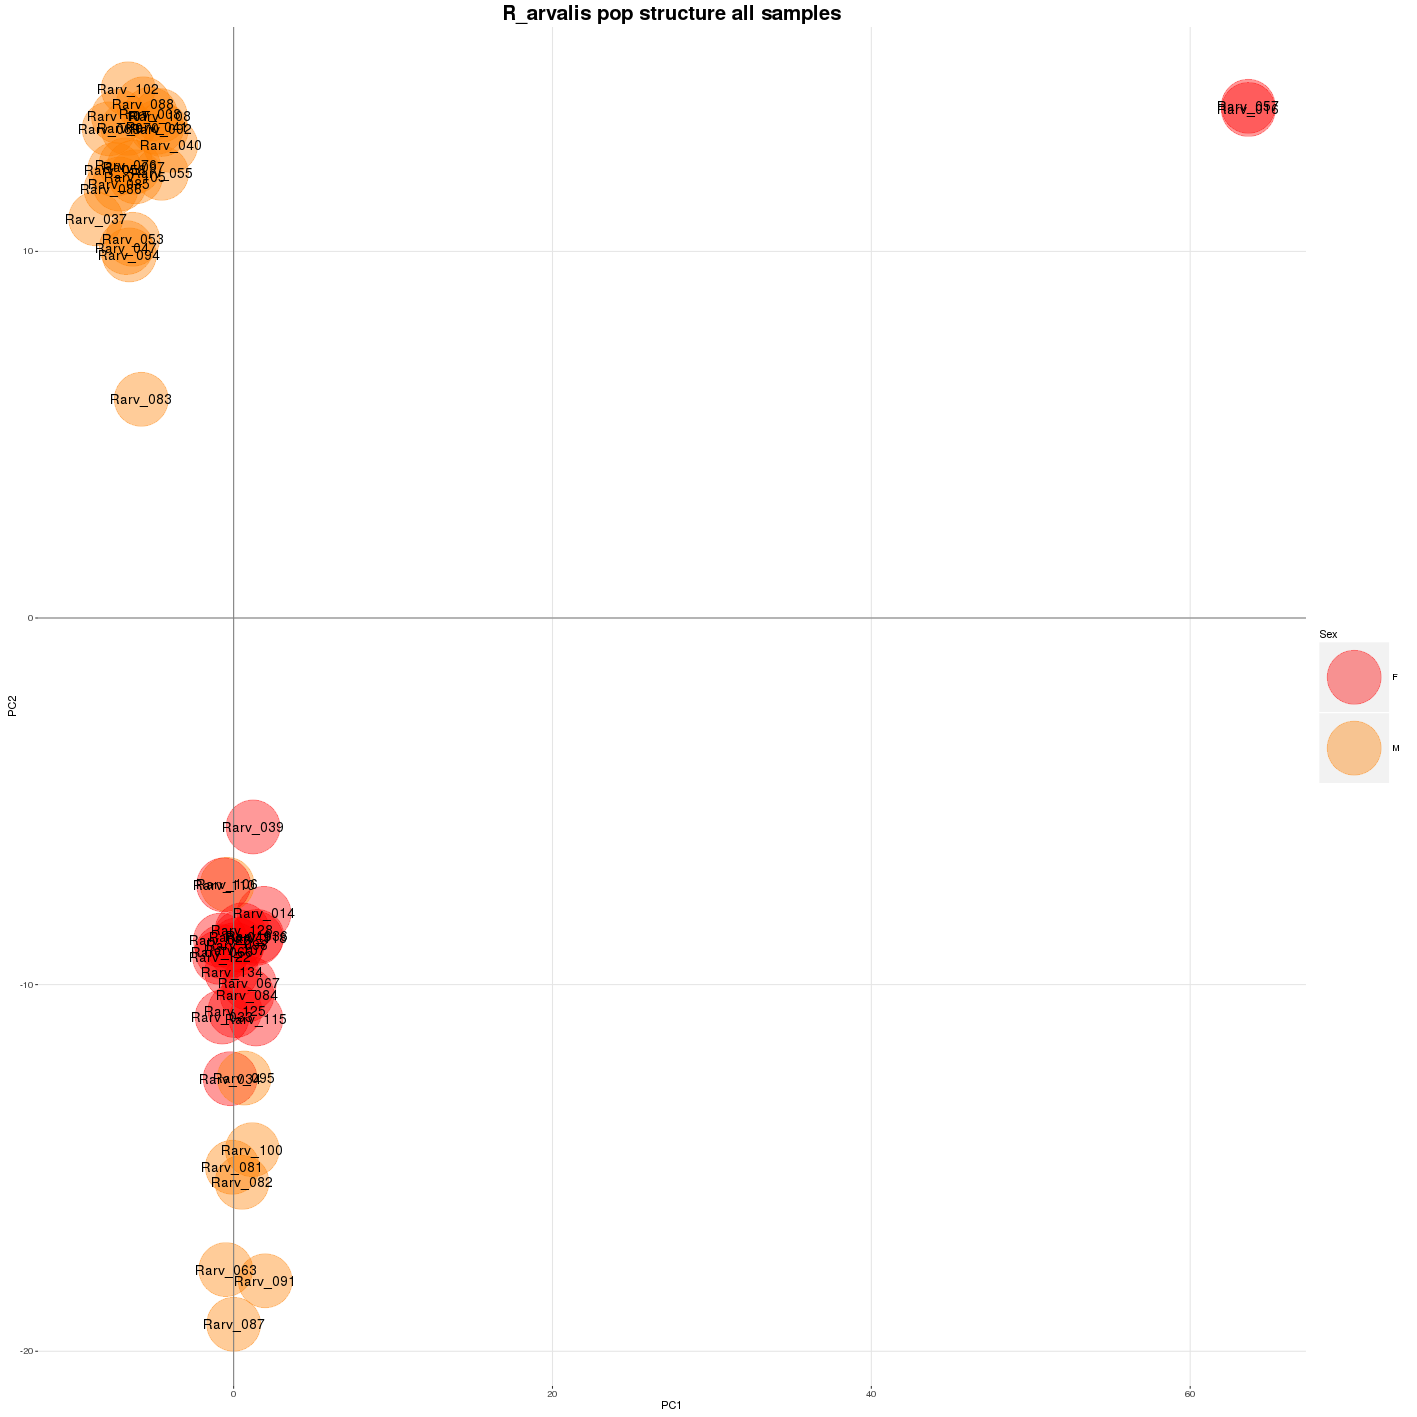

In [79]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function. First the PCs 1 and 2

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "R_arvalis pop structure all samples", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

Now plotting PCs 2 and 3 (ignore the PC labels)

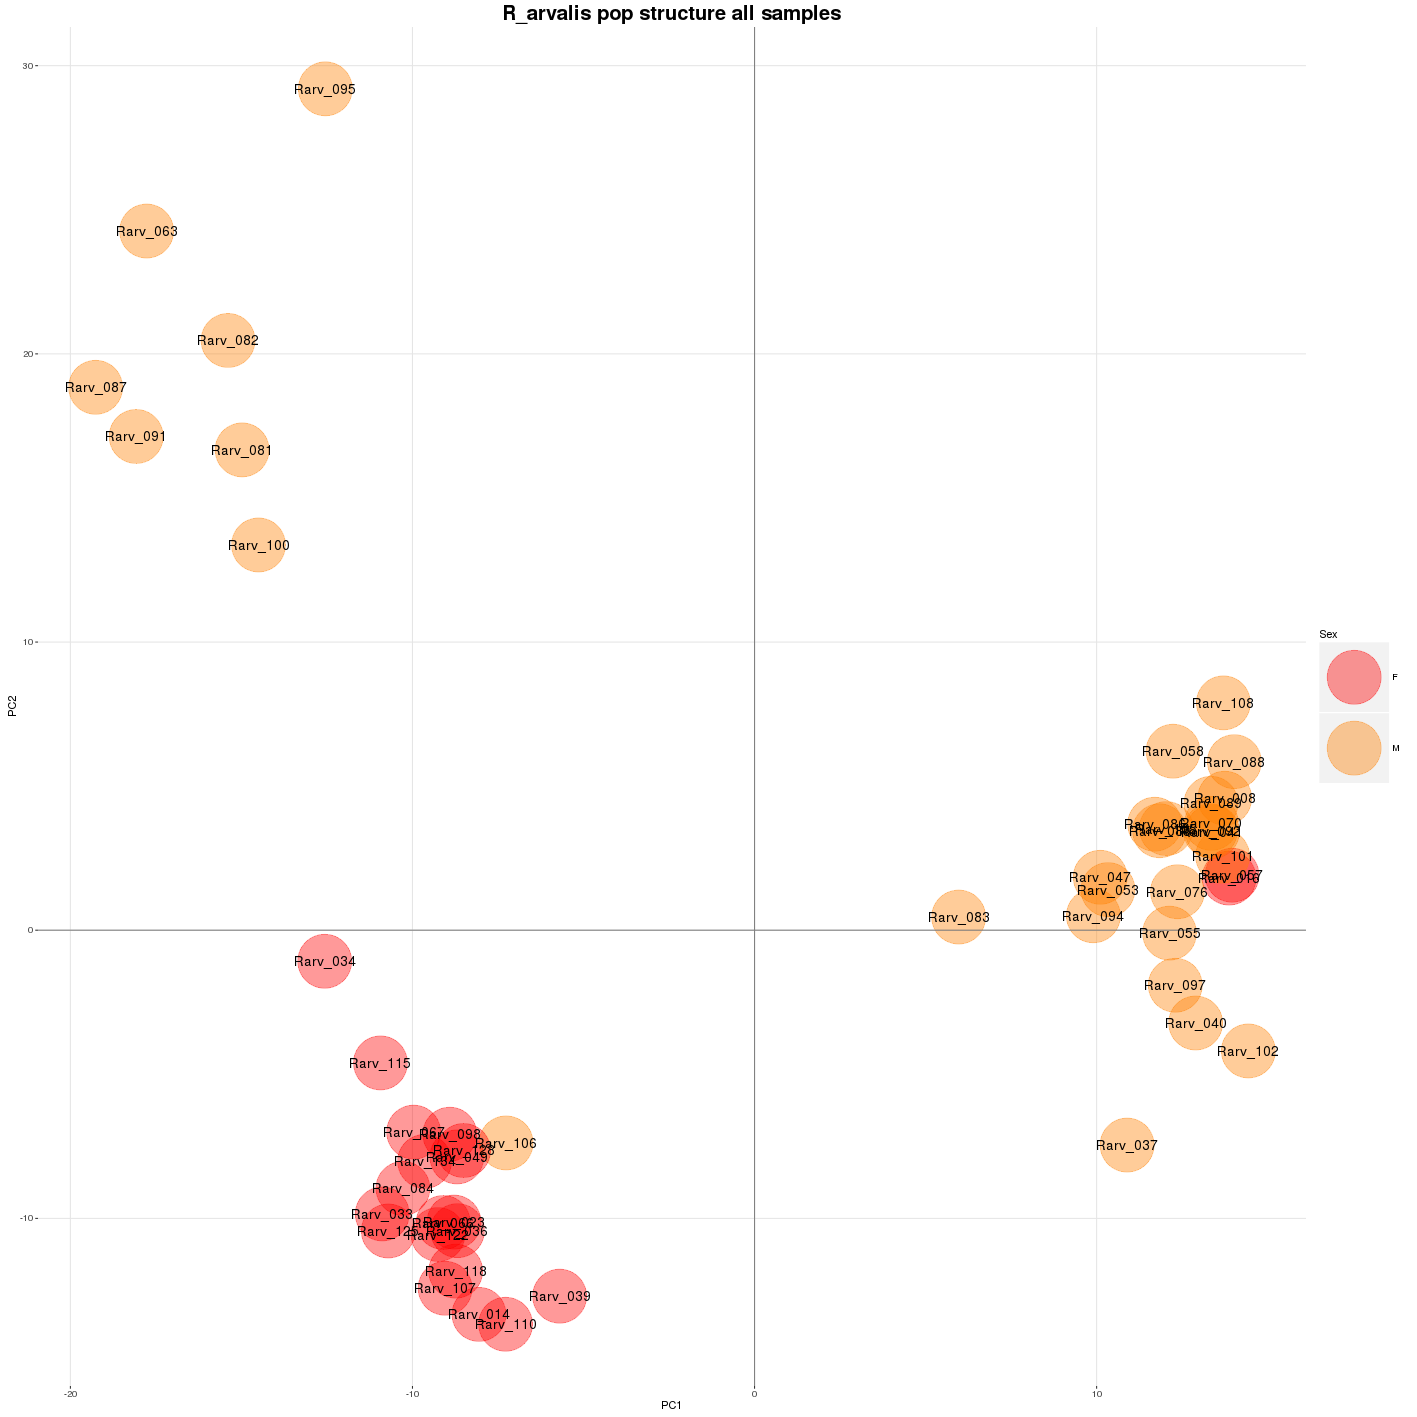

In [78]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(2,3), ## which components to plot
           Title = "R_arvalis pop structure all samples", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

So, for some reason, the first PC here captures the variation between Rarv_57 and Rarv_16 from the rest of the samples. When you look at the 2nd and 3rd PCs, which are more diagnostic for sex, you can see that they cluster with the larger haplogroup of males, and that there is one sample, Rarv_106 which clusters with females. This sample was removed from the previous analyses because it was quite bad quality, although not so bad that it can't be included here. 

So firstly Rarv_106 was ID'd as male, but looks XX. This is a good example of how PCAs can be useful for identifying samples with incorrect sex assignments. Even though this is normally best assessed using sex linked markers only, rather than the full dataset as here. I should also note however, that sex reversals do occur in the closely related <i>Rana temporaria</i>. So it is possible that this is indeed an XX male. Unfortunately the individual was released after the DNA sample was taken so we can't check this.

Secondly Rarv_057 and Rarv_016 fall outside of the rest of the samples on PC1 and also they look XY on PCs 2 and 3, but were IDd as female. 

However, a simple sex reversal does not explain why Rarv_057 and Rarv_016 are so distant from the other samples at the majority of their loci. 



Is this neutral structure? 

To answer this I will filter a vcf for all sex linked loci and include these samples in there.

In [25]:
vcf_path = "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_all/batch_1.vcf"

MISC.filter_vcf(vcf_path, relaxedXYset , "All_samples_XY_filtered_markers.vcf")

### So now to plot the PCA using only Sex-linked loci

In [26]:
%%bash

wd=/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_all/  ## just change this line

## All data 
sed 's/_/-/g' $wd/All_samples_XY_filtered_markers.vcf > $wd/All_samples_XY_filtered_markers.vcf.altered

~/Programs/plink_linux_x86_64/plink --vcf $wd/All_samples_XY_filtered_markers.vcf.altered --recode A --allow-extra-chr -out $wd/All_samples_XY_filtered_markers_plink


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_all//All_samples_XY_filtered_markers_plink.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_all//All_samples_XY_filtered_markers_plink
  --recode A
  --vcf /home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_all//All_samples_XY_filtered_markers.vcf.altered

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_all//All_samples_XY_filtered_markers_plink-temporary.bed
+
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_all//All_samples_XY_filtered_markers_plink-temporary.bim
+
/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_all//All_samples_XY_filtered_markers_plink-temporary.fam
written.
218 variants loaded from .bim file.
51 people (0 males, 0

In [27]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_all/") 

## All SNPs (about 80,000)
alldata <- read.PLINK('All_samples_XY_filtered_markers_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 

## Sex information:
sexes <- read.delim("../sex_info.txt", header = F)

## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(alldata, parallel = TRUE, n.cores = 6, nf = 5) 



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



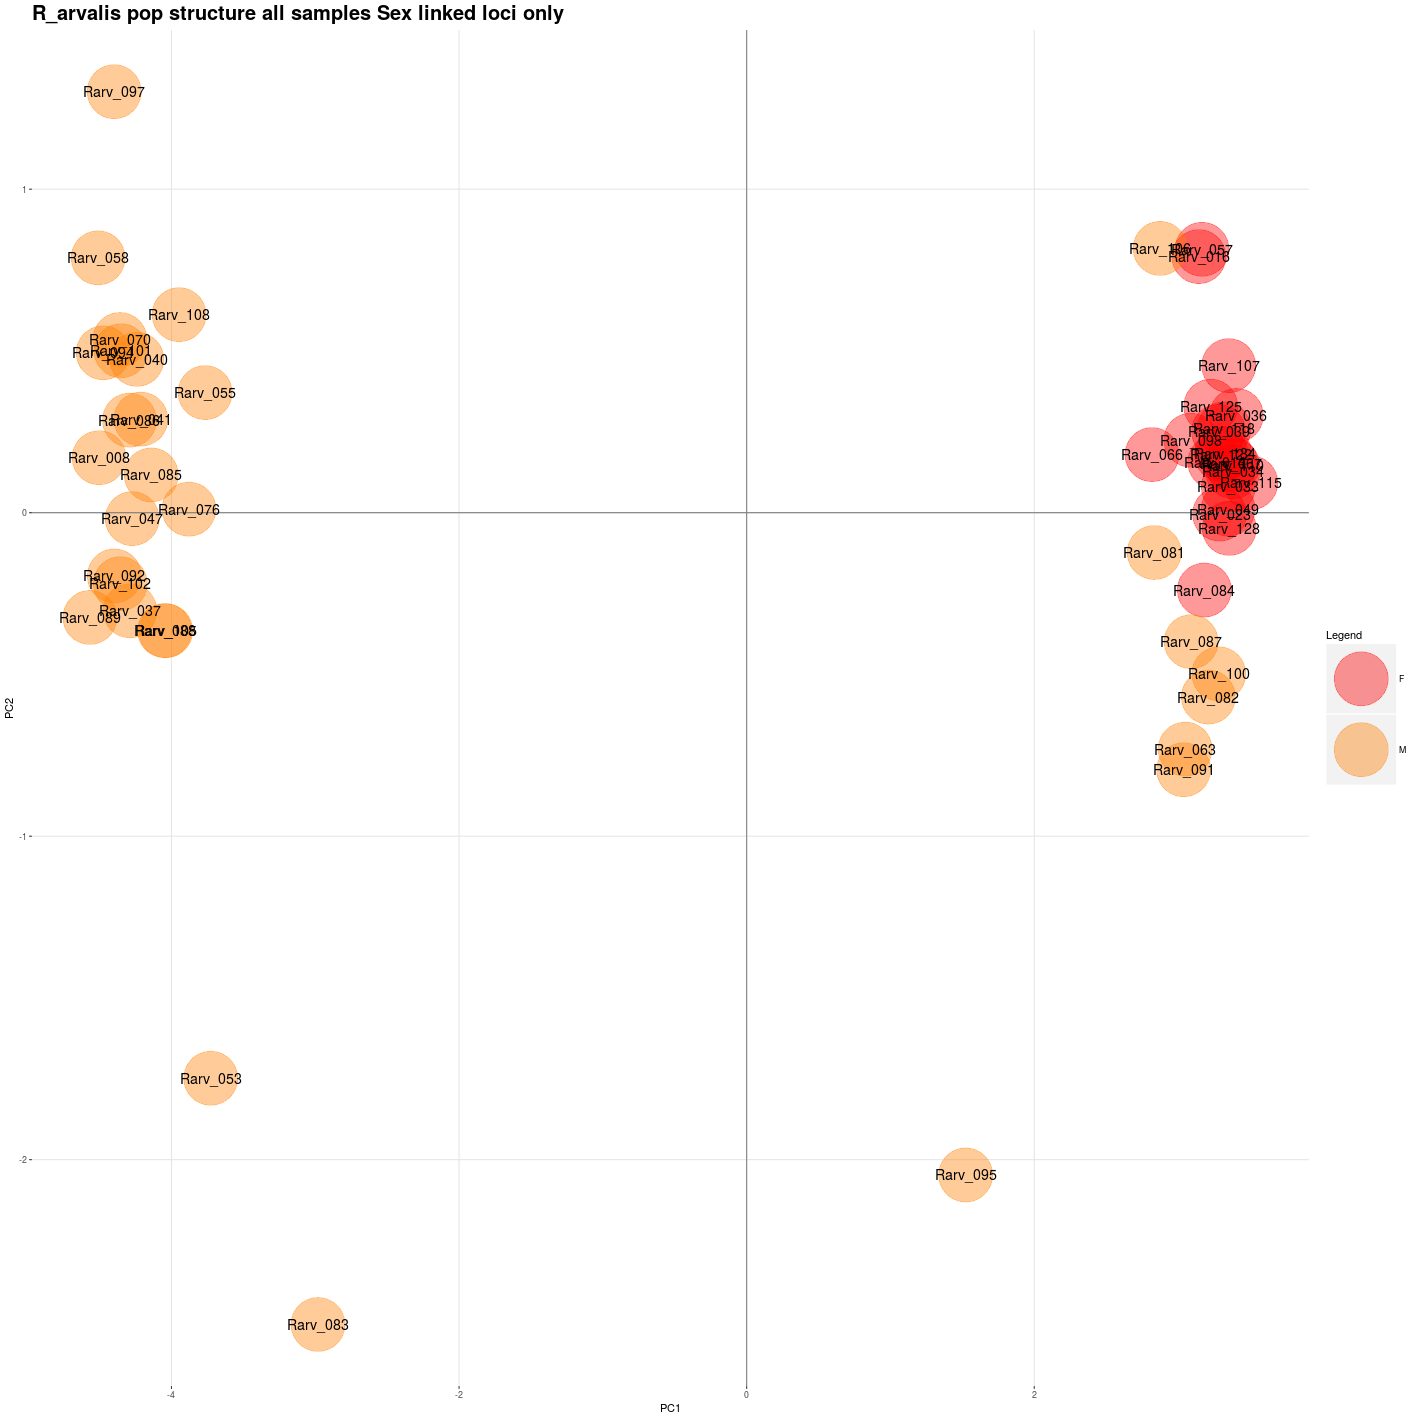

In [28]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "R_arvalis pop structure all samples Sex linked loci only", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

So there doesn't seem to be as much impact when looking just at the sex-linked variation. There is nothing particularly special about the data for these samples, i.e. high or low coverage, so it could just be that these are individuals with some introgression from another population. 

# Subsampling tests

In this section I will test the effect of three dataset characteristics on the ability to identify sex linked markers in this dataset. 

    - The effect of having multiple Y haplotypes in the population. 
    - The effect of the overall number of samples (when N males and N females is equal)
    - The effect of having a higher number of male or female samples in the dataset.
    
Below are just the Sex linked marker tests. The effect of these characteristics on the ratio of putative sex linked markers to false positives will be examined in the randomisations notebook. 

## The effect of having multiple haplotypes in the same population. . . . 

Question: Does having multiple Y haplotypes in a dataset confound the tests for sex linked markers?

We will run tests for sex linked markers in two datasets:

    Test 1. 12 males from the large Y haplogroup) and 12 females
    Test 2. 12 males (6 from each Y haplogroup) and the same 12 females.

Expect the number of sex linked markers found to be higher in 1. than 2.



### Test 1.

In [8]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_Subsample_oneHap/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW//Stacks/Populations_Subsample_oneHap/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.



##### Using SNP frequency approach #### 

Number of loci = 59905
Number of samples = 24
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 59904
Number of putative X linked snps = 135
Number of putative X linked tags = 135
Number of putative Z linked markers = 37
Number of putative Z linked tags = 37


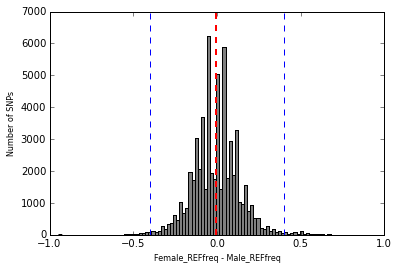


***DONE!***


##### Using SNP heterozygosity approach #####
 
Number of loci = 59905
Number of samples = 24
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 59904
Number of putative X linked snps = 160
Number of putative X linked tags = 160
Number of putative Z linked markers = 16
Number of putative Z linked tags = 16

 ### DONE! ### 


##### Using Sex specific tag approach ##### 


SUMMARY:
Number of females: 12
Number of males: 12
Number of Putative Y linked tags: 201
Number of Putative W linked tags: 50

 ### DONE! ###

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks

 ## After merging tags accross methods ## 

Final number of XY tags = 378
Final number of ZW tags = 102


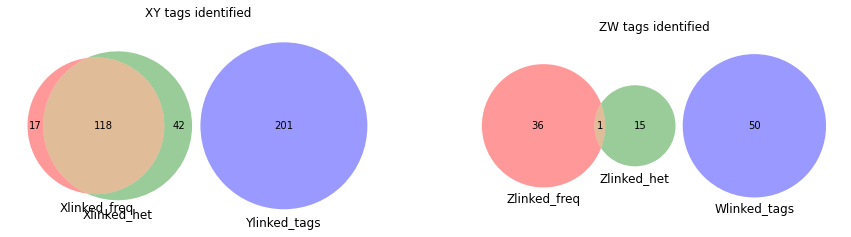

In [9]:
Test1_XYset, Test1_ZWset = MISC.Super_SLM_finder(Parameter_dict, "111")

### Test 2.

In [12]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_Subsample_twoHaps/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW//Stacks/Populations_Subsample_twoHaps/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.



##### Using SNP frequency approach #### 

Number of loci = 59705
Number of samples = 18
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 59704
Number of putative X linked snps = 168
Number of putative X linked tags = 168
Number of putative Z linked markers = 114
Number of putative Z linked tags = 114


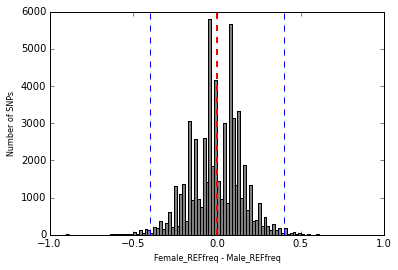


***DONE!***


##### Using SNP heterozygosity approach #####
 
Number of loci = 59705
Number of samples = 18
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 59704
Number of putative X linked snps = 86
Number of putative X linked tags = 86
Number of putative Z linked markers = 125
Number of putative Z linked tags = 125

 ### DONE! ### 


##### Using Sex specific tag approach ##### 


SUMMARY:
Number of females: 6
Number of males: 12
Number of Putative Y linked tags: 332
Number of Putative W linked tags: 140

 ### DONE! ###

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks

 ## After merging tags accross methods ## 

Final number of XY tags = 567
Final number of ZW tags = 370


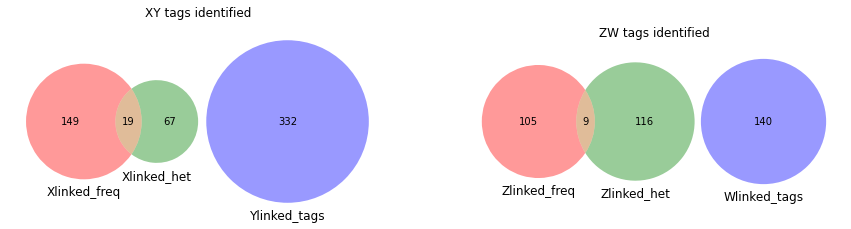

In [13]:
Test2_XYset, Test2_ZWset = MISC.Super_SLM_finder(Parameter_dict, "111")

You can see that there is a much greater difference between the number of XY-like and ZW-like markers found in the first test. Which is usually indicative of having fewer false positives. However this will formally be tested in the randomisations notebook. (SPOILER - its true, many more false positives with 2 Y haplotypes, to the point where we cannot say that any loci are sex linked).

## General downsampling tests

Here we will test the effect of simply reducing the overall number of samples in the dataset (keeping male and female ratios the same).

There are 29 and 19 males and females in the full dataset respectively. Of the 29 males, something like 21 have the same Y haplotype. So I will take 19 of these 21 males, all 19 females, and then downsample by 4 (2 males and 2 females) each time, running the sex linked marker tests search on each set. The randomisations for each one will be run in the randomisations notebook. 

I expect that as the sample number goes down, there will be fewer sex linked loci, and the number of false positives will increase, so the ratio of truly sex linked vs false positive rate should increase. 


## Down_1 19 males 19 females

In [48]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_Y_haplogroup_1/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW//Stacks/Populations_downsample_19_19/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.


In [49]:
Down_1_XYset, Down_1_ZWset = MISC.Super_SLM_finder(Parameter_dict, "010")


##### Using SNP heterozygosity approach #####
 
Number of loci = 58288
Number of samples = 40
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 58287
Number of putative X linked snps = 105
Number of putative X linked tags = 105
Number of putative Z linked markers = 4
Number of putative Z linked tags = 4

 ### DONE! ### 

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks

 ## After merging tags accross methods ## 

Final number of XY tags = 105
Final number of ZW tags = 4


## Down_2 17 males 17 females

In [50]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_Y_haplogroup_1/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW//Stacks/Populations_downsample_17_17/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.


In [51]:
Down_2_XYset, Down_2_ZWset = MISC.Super_SLM_finder(Parameter_dict, "010")


##### Using SNP heterozygosity approach #####
 
Number of loci = 58288
Number of samples = 40
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 58287
Number of putative X linked snps = 116
Number of putative X linked tags = 116
Number of putative Z linked markers = 5
Number of putative Z linked tags = 5

 ### DONE! ### 

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks

 ## After merging tags accross methods ## 

Final number of XY tags = 116
Final number of ZW tags = 5


## Down_3 15 males 15 females

In [52]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_Y_haplogroup_1/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW//Stacks/Populations_downsample_15_15/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.


In [53]:
Down_3_XYset, Down_3_ZWset = MISC.Super_SLM_finder(Parameter_dict, "010")


##### Using SNP heterozygosity approach #####
 
Number of loci = 58288
Number of samples = 40
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 58287
Number of putative X linked snps = 132
Number of putative X linked tags = 132
Number of putative Z linked markers = 11
Number of putative Z linked tags = 11

 ### DONE! ### 

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks

 ## After merging tags accross methods ## 

Final number of XY tags = 132
Final number of ZW tags = 11


## Down_4 13 males 13 females

In [28]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_Y_haplogroup_1/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW//Stacks/Populations_downsample_13_13/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.


In [29]:
Down_4_XYset, Down_4_ZWset = MISC.Super_SLM_finder(Parameter_dict, "010")


##### Using SNP heterozygosity approach #####
 
Number of loci = 58288
Number of samples = 40
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 58287
Number of putative X linked snps = 144
Number of putative X linked tags = 144
Number of putative Z linked markers = 18
Number of putative Z linked tags = 18

 ### DONE! ### 

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks

 ## After merging tags accross methods ## 

Final number of XY tags = 144
Final number of ZW tags = 18


## Down_5 11 males 11 females

In [36]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_Y_haplogroup_1/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW//Stacks/Populations_downsample_11_11/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.


In [37]:
Down_5_XYset, Down_5_ZWset = MISC.Super_SLM_finder(Parameter_dict, "010")


##### Using SNP heterozygosity approach #####
 
Number of loci = 58288
Number of samples = 40
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 58287
Number of putative X linked snps = 179
Number of putative X linked tags = 179
Number of putative Z linked markers = 39
Number of putative Z linked tags = 39

 ### DONE! ### 

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks

 ## After merging tags accross methods ## 

Final number of XY tags = 179
Final number of ZW tags = 39


## Down_6 9 males 9 females

In [38]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_Y_haplogroup_1/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW//Stacks/Populations_downsample_9_9/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.


In [39]:
Down_6_XYset, Down_6_ZWset = MISC.Super_SLM_finder(Parameter_dict, "010")


##### Using SNP heterozygosity approach #####
 
Number of loci = 58288
Number of samples = 40
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 58287
Number of putative X linked snps = 216
Number of putative X linked tags = 216
Number of putative Z linked markers = 70
Number of putative Z linked tags = 70

 ### DONE! ### 

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks

 ## After merging tags accross methods ## 

Final number of XY tags = 216
Final number of ZW tags = 70


## Down_7 7 males 7 females

In [30]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_Y_haplogroup_1/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW//Stacks/Populations_downsample_7_7/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.


In [31]:
Down_7_XYset, Down_7_ZWset = MISC.Super_SLM_finder(Parameter_dict, "010")


##### Using SNP heterozygosity approach #####
 
Number of loci = 58288
Number of samples = 40
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 58287
Number of putative X linked snps = 323
Number of putative X linked tags = 323
Number of putative Z linked markers = 192
Number of putative Z linked tags = 192

 ### DONE! ### 

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks

 ## After merging tags accross methods ## 

Final number of XY tags = 323
Final number of ZW tags = 192


## Down_8 5 males 5 females

In [40]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/Populations_Y_haplogroup_1/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW//Stacks/Populations_downsample_5_5/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.


In [41]:
Down_8_XYset, Down_8_ZWset = MISC.Super_SLM_finder(Parameter_dict, "010")


##### Using SNP heterozygosity approach #####
 
Number of loci = 58288
Number of samples = 40
Number of loci with too few samples = 1
Number of loci with low MAF = 0
Number of loci with enough data = 58285
Number of putative X linked snps = 1018
Number of putative X linked tags = 1018
Number of putative Z linked markers = 1116
Number of putative Z linked tags = 1116

 ### DONE! ### 

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks

 ## After merging tags accross methods ## 

Final number of XY tags = 1018
Final number of ZW tags = 1116


# Testing for a skew in the number of male vs female samples

## M19, F19

In [3]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_Y_haplogroup_1/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_skew_M19_F19/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.

Skew_M19_F19_XYset, Skew_M19_F19_ZWset = MISC.Super_SLM_finder(Parameter_dict, "010")


##### Using SNP heterozygosity approach #####
 
Number of loci = 58288
Number of samples = 40
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 58287
Number of putative X linked snps = 105
Number of putative X linked tags = 105
Number of putative Z linked markers = 4
Number of putative Z linked tags = 4

 ### DONE! ### 

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW

 ## After merging tags accross methods ## 

Final number of XY tags = 105
Final number of ZW tags = 4


## M17, F19

In [5]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_Y_haplogroup_1/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_skew_M17_F19/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.

Skew_M17_F19_XYset, Skew_M17_F19_ZWset = MISC.Super_SLM_finder(Parameter_dict, "010")


##### Using SNP heterozygosity approach #####
 
Number of loci = 58288
Number of samples = 40
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 58287
Number of putative X linked snps = 106
Number of putative X linked tags = 106
Number of putative Z linked markers = 4
Number of putative Z linked tags = 4

 ### DONE! ### 

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW

 ## After merging tags accross methods ## 

Final number of XY tags = 106
Final number of ZW tags = 4


## M15, F19

In [6]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_Y_haplogroup_1/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_skew_M15_F19/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.

Skew_M15_F19_XYset, Skew_M15_F19_ZWset = MISC.Super_SLM_finder(Parameter_dict, "010")


##### Using SNP heterozygosity approach #####
 
Number of loci = 58288
Number of samples = 40
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 58287
Number of putative X linked snps = 108
Number of putative X linked tags = 108
Number of putative Z linked markers = 5
Number of putative Z linked tags = 5

 ### DONE! ### 

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW

 ## After merging tags accross methods ## 

Final number of XY tags = 108
Final number of ZW tags = 5


## M13, F19

In [7]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_Y_haplogroup_1/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_skew_M13_F19/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.

Skew_M13_F19_XYset, Skew_M13_F19_ZWset = MISC.Super_SLM_finder(Parameter_dict, "010")


##### Using SNP heterozygosity approach #####
 
Number of loci = 58288
Number of samples = 40
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 58287
Number of putative X linked snps = 107
Number of putative X linked tags = 107
Number of putative Z linked markers = 5
Number of putative Z linked tags = 5

 ### DONE! ### 

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW

 ## After merging tags accross methods ## 

Final number of XY tags = 107
Final number of ZW tags = 5


## M11, F19

In [8]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_Y_haplogroup_1/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_skew_M11_F19/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.

Skew_M11_F19_XYset, Skew_M11_F19_ZWset = MISC.Super_SLM_finder(Parameter_dict, "010")


##### Using SNP heterozygosity approach #####
 
Number of loci = 58288
Number of samples = 40
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 58287
Number of putative X linked snps = 112
Number of putative X linked tags = 112
Number of putative Z linked markers = 10
Number of putative Z linked tags = 10

 ### DONE! ### 

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW

 ## After merging tags accross methods ## 

Final number of XY tags = 112
Final number of ZW tags = 10


## M9, F19

In [9]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_Y_haplogroup_1/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_skew_M9_F19/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.

Skew_M9_F19_XYset, Skew_M9_F19_ZWset = MISC.Super_SLM_finder(Parameter_dict, "010")


##### Using SNP heterozygosity approach #####
 
Number of loci = 58288
Number of samples = 40
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 58287
Number of putative X linked snps = 108
Number of putative X linked tags = 108
Number of putative Z linked markers = 11
Number of putative Z linked tags = 11

 ### DONE! ### 

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW

 ## After merging tags accross methods ## 

Final number of XY tags = 108
Final number of ZW tags = 11


## M7, F19

In [10]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_Y_haplogroup_1/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_skew_M7_F19/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.

Skew_M7_F19_XYset, Skew_M7_F19_ZWset = MISC.Super_SLM_finder(Parameter_dict, "010")


##### Using SNP heterozygosity approach #####
 
Number of loci = 58288
Number of samples = 40
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 58287
Number of putative X linked snps = 108
Number of putative X linked tags = 108
Number of putative Z linked markers = 22
Number of putative Z linked tags = 22

 ### DONE! ### 

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW

 ## After merging tags accross methods ## 

Final number of XY tags = 108
Final number of ZW tags = 22


## M5, F19

In [11]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_Y_haplogroup_1/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_skew_M5_F19/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.

Skew_M5_F19_XYset, Skew_M5_F19_ZWset = MISC.Super_SLM_finder(Parameter_dict, "010")


##### Using SNP heterozygosity approach #####
 
Number of loci = 58288
Number of samples = 40
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 58286
Number of putative X linked snps = 144
Number of putative X linked tags = 144
Number of putative Z linked markers = 59
Number of putative Z linked tags = 59

 ### DONE! ### 

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW

 ## After merging tags accross methods ## 

Final number of XY tags = 144
Final number of ZW tags = 59


## M19, F17

In [12]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_Y_haplogroup_1/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_skew_M19_F17/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.

Skew_M19_F17_XYset, Skew_M19_F17_ZWset = MISC.Super_SLM_finder(Parameter_dict, "010")


##### Using SNP heterozygosity approach #####
 
Number of loci = 58288
Number of samples = 40
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 58287
Number of putative X linked snps = 115
Number of putative X linked tags = 115
Number of putative Z linked markers = 5
Number of putative Z linked tags = 5

 ### DONE! ### 

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW

 ## After merging tags accross methods ## 

Final number of XY tags = 115
Final number of ZW tags = 5


## M19, F15

In [13]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_Y_haplogroup_1/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_skew_M19_F15/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.

Skew_M19_F15_XYset, Skew_M19_F15_ZWset = MISC.Super_SLM_finder(Parameter_dict, "010")


##### Using SNP heterozygosity approach #####
 
Number of loci = 58288
Number of samples = 40
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 58287
Number of putative X linked snps = 127
Number of putative X linked tags = 127
Number of putative Z linked markers = 8
Number of putative Z linked tags = 8

 ### DONE! ### 

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW

 ## After merging tags accross methods ## 

Final number of XY tags = 127
Final number of ZW tags = 8


## M19, F13

In [14]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_Y_haplogroup_1/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_skew_M19_F13/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.

Skew_M19_F13_XYset, Skew_M19_F13_ZWset = MISC.Super_SLM_finder(Parameter_dict, "010")


##### Using SNP heterozygosity approach #####
 
Number of loci = 58288
Number of samples = 40
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 58287
Number of putative X linked snps = 142
Number of putative X linked tags = 142
Number of putative Z linked markers = 10
Number of putative Z linked tags = 10

 ### DONE! ### 

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW

 ## After merging tags accross methods ## 

Final number of XY tags = 142
Final number of ZW tags = 10


## M19, F11

In [15]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_Y_haplogroup_1/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_skew_M19_F11/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.

Skew_M19_F11_XYset, Skew_M19_F11_ZWset = MISC.Super_SLM_finder(Parameter_dict, "010")


##### Using SNP heterozygosity approach #####
 
Number of loci = 58288
Number of samples = 40
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 58287
Number of putative X linked snps = 160
Number of putative X linked tags = 160
Number of putative Z linked markers = 13
Number of putative Z linked tags = 13

 ### DONE! ### 

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW

 ## After merging tags accross methods ## 

Final number of XY tags = 160
Final number of ZW tags = 13


## M19, F9

In [16]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_Y_haplogroup_1/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_skew_M19_F9/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.

Skew_M19_F9_XYset, Skew_M19_F9_ZWset = MISC.Super_SLM_finder(Parameter_dict, "010")


##### Using SNP heterozygosity approach #####
 
Number of loci = 58288
Number of samples = 40
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 58287
Number of putative X linked snps = 186
Number of putative X linked tags = 186
Number of putative Z linked markers = 17
Number of putative Z linked tags = 17

 ### DONE! ### 

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW

 ## After merging tags accross methods ## 

Final number of XY tags = 186
Final number of ZW tags = 17


## M19, F7

In [17]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_Y_haplogroup_1/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_skew_M19_F7/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.

Skew_M19_F7_XYset, Skew_M19_F7_ZWset = MISC.Super_SLM_finder(Parameter_dict, "010")


##### Using SNP heterozygosity approach #####
 
Number of loci = 58288
Number of samples = 40
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 58287
Number of putative X linked snps = 232
Number of putative X linked tags = 232
Number of putative Z linked markers = 24
Number of putative Z linked tags = 24

 ### DONE! ### 

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW

 ## After merging tags accross methods ## 

Final number of XY tags = 232
Final number of ZW tags = 24


## M19, F5

In [18]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_Y_haplogroup_1/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Populations_skew_M19_F5/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.1 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.

Skew_M19_F5_XYset, Skew_M19_F5_ZWset = MISC.Super_SLM_finder(Parameter_dict, "010")


##### Using SNP heterozygosity approach #####
 
Number of loci = 58288
Number of samples = 40
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 58287
Number of putative X linked snps = 308
Number of putative X linked tags = 308
Number of putative Z linked markers = 102
Number of putative Z linked tags = 102

 ### DONE! ### 

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rarvalis_NEW

 ## After merging tags accross methods ## 

Final number of XY tags = 308
Final number of ZW tags = 102
